In [1]:
import symengine
import cobra
from cobra.core import *
from cobra.io import load_json_model
from copy import deepcopy
import pickle
import pandas as pd
import glob
import json
from optlang.symbolics import Zero
from cobra.core import Reaction
import sys
import operator
from cobra.util.util import format_long_string
import numpy as np
import cobra.util.solver as sutil

import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns; sns.set()
from IPython.display import clear_output

import random
import statistics
from statistics import mean
import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_gaussian_quantiles
from sklearn.metrics import accuracy_score

from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from functions.canyun_functions import *

In [2]:
# import sys
# !{sys.executable} -m pip install symengine

## Load Biolog Data

In [3]:
# Load Biolog Well ID to BIGG metabolite ID conversion table
df_conversion = pd.read_csv("bigg-modelSEED-biolog-conversion.csv",index_col = 0)
conv_dict = {}
for index, row in df_conversion.iterrows():
    string = str(row['BIGG_id'])#.replace('\xa0', '')
    carbon_sources = string.split(', ')
    try:
        if carbon_sources[0] != 'nan':
            carbon_sources[0] = carbon_sources[0] + '_e'
    except:
        pass
    try:
        carbon_sources[1] = carbon_sources[1] + '_e'
    except:
        pass
    conv_dict[index] = carbon_sources
print('Number of well IDs:', len(list(conv_dict.values())))

Number of well IDs: 384


In [4]:
# Visual check there are no duplicate metabolites in wells with two primary nutrient sources
for key, met_list in conv_dict.items():
    if len(met_list) == 2:
        print(met_list)

['mal__D_e', 'mal__L_e']
['12ppd__R_e', '12ppd__S_e']
['2hb_e', '2hbut_e']
['stchs_e', 'stys_e']
['crn_e', 'crn__D_e']
['alagly_e', 'L_alagly_e']
['ppac_e', 'phnac_e']


In [5]:
# Check for and record wells with duplicate metabolites
mets = []
# Add all two metabolite lists to metabolite_set before checking for dublicates
for key, met_list in conv_dict.items():
    if len(met_list) == 2:
        for met in met_list:
            mets.append(met)
metabolite_set = set(mets)

duplicate_wells = []
for key in sorted(conv_dict.keys()): # set list order to ensure the same wells are removed
    met_list = conv_dict[key]
    if len(met_list) == 1 and met_list[0] not in metabolite_set:
        metabolite_set = metabolite_set | set(met_list) # Add metabolite ID to metabolite set
    elif len(met_list) == 1 and met_list[0] in metabolite_set:
        if met_list[0] != 'nan':
            duplicate_wells.append(key)
    else:
        continue
        
print('Number of wells with duplicate metabolites:', len(set(duplicate_wells)))

Number of wells with duplicate metabolites: 50


In [6]:
# Load Universal model and adjust using ML1515
universal = pickle.load(open('carveme_universal_moutinho.pickle',"rb"))
universal.groups = DictList()
# Add ML1515 reactions to Universal
ML1515 = cobra.io.load_json_model('iML1515.json')
ML1515.groups = DictList()
universal_ML1515 = deepcopy(universal)
rxns_to_add = []
for rxn in ML1515.reactions:
    try:
        universal.reactions.get_by_id(rxn.id)
    except:
        rxns_to_add.append(deepcopy(rxn))
universal_ML1515.add_reactions(rxns_to_add)

# Make new Biomass rxn

# Metabolites that are not in the CarveMe biomass reaction
extra_metabolites = ['kdo2lipid4_e', 'udcpdp_c', 'murein5px4p_p', 'btn_c', 'pe161_p', 
                     'pe160_p', 'sheme_c', '2fe2s_c', '4fe4s_c', 'pheme_c']

bm_rxn = Reaction('Biomass')
bm_rxn.name = "Custom Biomass for CANYUNs"
bm_rxn.lower_bound = 0.0
bm_rxn.upper_bound = 1000.0

met_dict = dict()
old_met_dict = universal_ML1515.reactions.get_by_id('BIOMASS_Ec_iML1515_core_75p37M').metabolites
for met in old_met_dict.keys():
    if met.id not in extra_metabolites:
        met_dict[met] = old_met_dict[met]

bm_rxn.add_metabolites(met_dict)

universal_ML1515.add_reactions([bm_rxn])

# Turn off old biomass reaction
old_bm = universal_ML1515.reactions.get_by_id('BIOMASS_Ec_iML1515_core_75p37M')
old_bm.lower_bound = 0
old_bm.upper_bound = 0

# Corrections for mass imbalanced reactions
universal_ML1515.metabolites.get_by_id("tmp_c").formula = 'O9P3'
universal_ML1515.metabolites.get_by_id("cyst__L_e").formula = 'C7H14N2O4S'
universal_ML1515.metabolites.get_by_id("5mthf_c").formula='C20H23N7O6'
universal_ML1515.metabolites.get_by_id("tmp_e").formula = 'O9P3'

old_rxn = universal_ML1515.reactions.get_by_id('MTHFR2')
new_rxn = Reaction(old_rxn.id)
new_rxn.name = old_rxn.name
new_rxn.lower_bound = old_rxn.lower_bound
new_rxn.upper_bound = old_rxn.upper_bound

# Remove extra h+ ion from equation
met_to_change = 'h_c'
old_mets = old_rxn.metabolites
new_mets = dict()
for met, coef in old_rxn.metabolites.items():
    if not met.id == met_to_change:
        new_mets[met] = coef
    else:
        new_mets[met] = -1.0
new_mets
new_rxn.add_metabolites(new_mets)
# print(new_rxn.check_mass_balance())
# new_rxn
old_rxn.remove_from_model()
universal_ML1515.add_reactions([new_rxn])

old_rxn = universal_ML1515.reactions.get_by_id('MTHFR3')
new_rxn = Reaction(old_rxn.id)
new_rxn.name = old_rxn.name
new_rxn.lower_bound = old_rxn.lower_bound
new_rxn.upper_bound = old_rxn.upper_bound

# Remove extra h+ ion from equation
met_to_change = 'h_c'
old_mets = old_rxn.metabolites
new_mets = dict()
for met, coef in old_rxn.metabolites.items():
    if not met.id == met_to_change:
        new_mets[met] = coef
    else:
        new_mets[met] = -1.0
new_mets
new_rxn.add_metabolites(new_mets)
old_rxn.remove_from_model()
universal_ML1515.add_reactions([new_rxn])

In [8]:
# Check for all extracellular metabolites
missing_e_mets = []
missing_c_mets = []
missing_e_met_keys = []
missing_c_met_keys = []
for key, mets in conv_dict.items():
    for met_id in mets:
        if met_id != 'nan':
            try:
                universal_ML1515.metabolites.get_by_id(met_id)
            except:
                missing_e_mets.append(met_id)
                missing_e_met_keys.append(key)
                try:
                    met_id_c = met_id[:-1] + 'c'
                    universal_ML1515.metabolites.get_by_id(met_id_c)
                except:
                    missing_c_mets.append(met_id_c)
                    missing_c_met_keys.append(key)
print(len(missing_e_mets))
print(len(missing_c_mets))

83
63


In [9]:
# Load growth condition data
df_gng = pd.read_csv("EC_g_ng_2.csv",index_col = 0)
# Make dictionary from growth/no growth data
gng_dict = {}
for index, row in df_gng.iterrows():
    gng_dict[index] = [row['aerobic'], row['anaerobic']]
gng_dict['PM1A1']

gng_dict_long = dict()
for key, vals in gng_dict.items():
    if vals[0] > 0.0: # Aerobic Growth
        gng_dict_long[key+'_1'] = 1.0
    if vals[1] > 0.0: # Anaerobic Growth
        gng_dict_long[key+'_0'] = 1.0
    if vals[0] == 0.0: # Aerobic No Growth
        gng_dict_long[key+'_1'] = 0.0
    if vals[1] == 0.0: # Anaerobic No Growth
        gng_dict_long[key+'_0'] = 0.0

In [10]:
ng = 0
g = 0
for key, val in gng_dict_long.items():
    if val == 0:
        ng += 1
    elif val == 1:
        g += 1
print('Percent No Growth conditions:', round(100*ng/(g+ng),1))
print('Percent Growth Conditions', round(100*g/(g+ng),1))

Percent No Growth conditions: 36.7
Percent Growth Conditions 63.3


In [11]:
nan_wells =[]
for key, mets in conv_dict.items():
    for met in mets:
        if met == 'nan':
            nan_wells.append(key)
useless_wells = nan_wells + missing_e_met_keys # + duplicate_wells
print('Number of Biolog wells that we cannot simulate with:', len(set(useless_wells)))

Number of Biolog wells that we cannot simulate with: 171


In [12]:
for key in missing_e_met_keys:
    if key not in missing_c_met_keys:
        print(key, str(gng_dict[key]))

PM2AD11 [0, -1]
PM2AE3 [0, -1]
PM2AE4 [0, -1]
PM2AE9 [0, -1]
PM2AG3 [0, -1]
PM2AH3 [0, -1]
PM3BA2 [1, -1]
PM3BC7 [-1, -1]
PM3BD1 [0, -1]
PM3BD3 [0, -1]
PM3BD4 [0, -1]
PM3BG11 [1, -1]
PM4A5 [1, -1]
PM4A12 [1, -1]
PM4B5 [1, -1]
PM4B12 [0, -1]
PM4C5 [1, -1]
PM4F12 [1, -1]
PM4G10 [1, -1]
PM4H4 [0, -1]


In [13]:
# Make custom media set for universal_ML1515
base_media = ['fe3_e','h_e','mn2_e','fe2_e','zn2_e','mg2_e','ca2_e','ni2_e','cu2_e', 'co2_e',
              'sel_e','cobalt2_e','h2o_e','mobd_e','k_e','na1_e','cl_e','tungs_e','slnt_e']

s = ['so4_e'] # Sulfate
p = ['pi_e'] # Phosphate
n = ['nh4_e'] # Ammonium
c = ['pyr_e'] # Pyruvate
o = ['o2_e'] # Oxygen

well_id_media_dict_ML1515 = dict()
for key, mets in conv_dict.items():
    if not key in set(useless_wells): # skip over keys for wells that aren't useful (missing mets)
        if gng_dict[key][0] >= 0.0: # If there is data for the media condition
            # aerobic = 1
            dict_key = key+'_1'
            # Alt carbon sources
            if key.startswith('PM1') or key.startswith('PM2'): 
                well_id_media_dict_ML1515[dict_key] = base_media + s + p + n + o + mets
            # Alt nitrogen sources
            elif key.startswith('PM3'): 
                well_id_media_dict_ML1515[dict_key] = base_media + s + p + c + o + mets
            # Alt phosphorus sources
            elif key.startswith('PM4A') or key.startswith('PM4B') or key.startswith('PM4C') or key.startswith('PM4D') or key.startswith('PM4E'):
                well_id_media_dict_ML1515[dict_key] = base_media + s + c + n + o + mets
            # Alt Sulphur sources
            elif key.startswith('PM4F') or key.startswith('PM4G') or key.startswith('PM4H'):
                well_id_media_dict_ML1515[dict_key] = base_media + p + c + n + o + mets
            else:
                print('ERROR')
        if gng_dict[key][1] >= 0.0: # If there is data for the media condition
            # anaerobic = 0
            dict_key = key+'_0'
            # Alt carbon sources
            if key.startswith('PM1') or key.startswith('PM2'): 
                well_id_media_dict_ML1515[dict_key] = base_media + s + p + n + mets
            # Alt nitrogen sources
            elif key.startswith('PM3'): 
                well_id_media_dict_ML1515[dict_key] = base_media + s + p + c + mets
            # Alt phosphorus sources
            elif key.startswith('PM4A') or key.startswith('PM4B') or key.startswith('PM4C') or key.startswith('PM4D') or key.startswith('PM4E'):
                well_id_media_dict_ML1515[dict_key] = base_media + s + c + n + mets
            # Alt Sulphur sources
            elif key.startswith('PM4F') or key.startswith('PM4G') or key.startswith('PM4H'):
                well_id_media_dict_ML1515[dict_key] = base_media + p + c + n + mets
            else:
                print('ERROR')
                
del well_id_media_dict_ML1515['PM1B7_0']

In [14]:
len(well_id_media_dict_ML1515)

273

In [15]:
%config InlineBackend.figure_format = 'svg'
sns.set_theme(style="whitegrid")
sns.set_palette("colorblind")
colors = sns.color_palette("colorblind", 10)
muted = sns.color_palette("muted", 10)

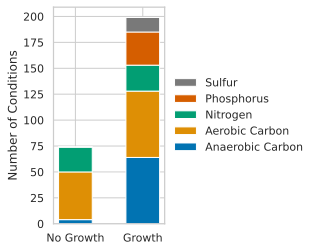

In [16]:
aerobic_carbon_no_growth = 0
aerobic_carbon_growth = 0
anaerobic_carbon_no_growth = 0
anaerobic_carbon_growth = 0
nitrogen_no_growth = 0
nitrogen_growth = 0
phosphorus_no_growth = 0
phosphorus_growth = 0
sulfur_no_growth = 0
sulfur_growth = 0

for key in well_id_media_dict_ML1515.keys():
    # Carbon
    if key.startswith('PM1') or key.startswith('PM2'):
        if key[-2:] == '_1':
            if gng_dict_long[key] == 0:
                aerobic_carbon_no_growth += 1
            elif gng_dict_long[key] == 1:
                aerobic_carbon_growth += 1
        if key[-2:] == '_0':
            if gng_dict_long[key] == 0:
                anaerobic_carbon_no_growth += 1
            elif gng_dict_long[key] == 1:
                anaerobic_carbon_growth += 1
    # Alt nitrogen sources
    elif key.startswith('PM3'):
        if gng_dict_long[key] == 0:
            nitrogen_no_growth += 1
        elif gng_dict_long[key] == 1:
            nitrogen_growth += 1
    # Alt phosphorus sources
    elif key.startswith('PM4A') or key.startswith('PM4B') or key.startswith('PM4C') or key.startswith('PM4D') or key.startswith('PM4E'):
        if gng_dict_long[key] == 0:
            phosphorus_no_growth += 1
        elif gng_dict_long[key] == 1:
            phosphorus_growth += 1
    # Alt Sulfur sources
    elif key.startswith('PM4F') or key.startswith('PM4G') or key.startswith('PM4H'):
        if gng_dict_long[key] == 0:
            sulfur_no_growth += 1
        elif gng_dict_long[key] == 1:
            sulfur_growth += 1
    else:
        print('ERROR')
        
ind = np.arange(2)
width = 0.5

anc = [anaerobic_carbon_no_growth, anaerobic_carbon_growth]

ac = [aerobic_carbon_no_growth, aerobic_carbon_growth]

n_ng = anaerobic_carbon_no_growth + aerobic_carbon_no_growth
n_g = anaerobic_carbon_growth + aerobic_carbon_growth
n_bottom = [n_ng, n_g]
n = [nitrogen_no_growth, nitrogen_growth]

p_ng = n_ng + nitrogen_no_growth
p_g = n_g + nitrogen_growth
p_bottom = [p_ng, p_g]
p = [phosphorus_no_growth, phosphorus_growth]

s_ng = p_ng + phosphorus_no_growth
s_g = p_g + phosphorus_growth
s_bottom = [s_ng, s_g]
s = [sulfur_no_growth, sulfur_growth]

%config InlineBackend.figure_format = 'svg'
plt.figure(figsize = (2, 4))

p1 = plt.bar(ind, anc, width)
p2 = plt.bar(ind, ac, width, bottom=anc)
p3 = plt.bar(ind, n, width, bottom=n_bottom)
p4 = plt.bar(ind, p, width, bottom=p_bottom)
p5 = plt.bar(ind, s, width, bottom=s_bottom, color=muted[7])

plt.ylabel('Number of Conditions')
plt.xticks(ind, ('No Growth','Growth'))

plt.legend((p5[0], p4[0], p3[0], p2[0], p1[0]),
           ('Sulfur', 'Phosphorus', 'Nitrogen', 'Aerobic Carbon', 'Anaerobic Carbon'),
            loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.show()

In [17]:
# Prep Universal_ML1515 for use moving forward

# Turn off old biomass reactions from CarveMe database
universal_ML1515.reactions.get_by_id('Growth').lower_bound = 0.0
universal_ML1515.reactions.get_by_id('Growth').upper_bound = 0.0
universal_ML1515.reactions.get_by_id('BIOMASS_Ec_iML1515_core_75p37M').lower_bound = 0.0
universal_ML1515.reactions.get_by_id('BIOMASS_Ec_iML1515_core_75p37M').upper_bound = 0.0
universal_ML1515.reactions.get_by_id('ATPM').lower_bound = 0.0

# Add Exchange Reactions if needed
met_id_list = []
for media_list in well_id_media_dict_ML1515.values():
    for met in media_list:
        # Search for exchange reactions
        try:
            temp_exchange = universal_ML1515.reactions.get_by_id('EX_'+ met)
        except:
            met_id_list.append(met)
met_id_set = set(met_id_list)
print('Number of exchange reactions missing:',len(met_id_set))

# Add missing exchanges to Universal
for met_id in met_id_set:
    try:
        ex_rxn = Reaction('EX_' + met_id)
        ex_rxn.name = "Exchange reaction for " + met_id
        ex_rxn.lower_bound = 0.0
        ex_rxn.upper_bound = 1000.0
        met = universal_ML1515.metabolites.get_by_id(met_id)
        ex_rxn.add_metabolites({met:-1})
        universal_ML1515.add_reactions([ex_rxn])
        print(met_id, ': Added')
    except:
        print('ERROR:', met_id)

print('Number of reactions in Universal_ML1515:', len(universal_ML1515.reactions))

Number of exchange reactions missing: 0
Number of reactions in Universal_ML1515: 6571


In [18]:
# Check universal_ML1515 for mass generating loops with semi-novel algorithm 

universal_ML1515_snks = deepcopy(universal_ML1515)

# Removal of reactions to fix the mass generating loops identified.
trouble_rxn_ids = pickle.load(open('trouble_reaction_ids.pickle', 'rb'))
for rxn_id in trouble_rxn_ids+['METS']:
    rxn = universal_ML1515_snks.reactions.get_by_id(rxn_id)
    rxn.lower_bound = 0.0
    rxn.upper_bound = 0.0

rxn_ids = [rxn.id for rxn in universal_ML1515_snks.reactions]
# Add any missing intracellular sink reactions
for met in universal_ML1515_snks.metabolites:
    if met.id.endswith('_p') or met.id.endswith('_c'):
        if 'SNK_' + met.id not in rxn_ids:
            snk_rxn = Reaction('SNK_' + met.id)
            snk_rxn.name = "Sink reaction for " + met.id
            snk_rxn.lower_bound = 0.0
            snk_rxn.upper_bound = 0.0
            snk_rxn.add_metabolites({met:-1})
            universal_ML1515_snks.add_reactions([snk_rxn])

# Turn off Biomass reaction
universal_ML1515_snks.reactions.get_by_id('Biomass').lower_bound = 0.0
universal_ML1515_snks.reactions.get_by_id('Biomass').upper_bound = 0.0
            
# Set exchanges to allow all extracellular metabolites leave the system
for rxn in universal_ML1515_snks.reactions:
    if rxn.id.startswith('EX_'):
        rxn.lower_bound = 0.0    # Don't allow mets in
        rxn.upper_bound = 1000.0 # Allow mets out

# Set all intracellular sink reactions open to allow mets out
for rxn in universal_ML1515_snks.reactions:
    if rxn.id.startswith('SNK_'):
        rxn.upper_bound = 1000.0

expr = Zero
for rxn in universal_ML1515_snks.reactions:
    if rxn.id.startswith('SNK_'): #  and rxn.id != 'SNK_h_c' and rxn.id != 'SNK_h_p'
        if rxn.upper_bound != 0.0:
            expr += 1.0 * rxn.forward_variable
            expr += 1.0 * rxn.reverse_variable

universal_ML1515_snks.objective = universal_ML1515_snks.problem.Objective(expr, direction='max', sloppy=True)
universal_ML1515_snks.solver.update()
solution = universal_ML1515_snks.optimize()

# Save reactions that carry flux
active_rxns_loops = set([rxn.id for rxn in universal_ML1515_snks.reactions if abs(solution.fluxes[rxn.id]) > 1e-6])
print(solution.objective_value)
if abs(solution.objective_value) < 1e-6:
    print('No mass generation!')

print(universal_ML1515_snks.solver.status)

# Check for mass imbalanced reactions
for rxn_id in active_rxns_loops:
    if rxn_id.startswith('SNK'):
        print('Metabolite produced:', rxn_id)

if abs(solution.objective_value) > 1e-6:
    balanced_rxns = []
    charge_only_rxns = []
    mass_imbalanced = []

    for rxn_id in active_rxns_loops:
        rxn = universal_ML1515_snks.reactions.get_by_id(rxn_id)
        try:
            if not rxn.check_mass_balance(): #Check if the dictionary is empty
                balanced_rxns.append(rxn.id)
            elif (list(rxn.check_mass_balance().keys())[0] == 'charge') & (len(list(rxn.check_mass_balance().keys())) == 1):
                charge_only_rxns.append(rxn.id)
            else:
                mass_imbalanced.append(rxn.id)
                print(rxn.id, rxn.check_mass_balance())
                try:
                    print(usage_dict_ML1515[rxn_id])
                    print(ML1515.reactions.get_by_id(rxn_id))
                except:
                    print('^ Safe to remove ^')
        except:
            mass_imbalanced.append(rxn.id)
            print(rxn.id, rxn.check_mass_balance())

    print(len(balanced_rxns))
    print(len(charge_only_rxns))
    print(len(mass_imbalanced))
    print(mass_imbalanced)
    
# Removal of reactions to fix the mass generating loops identified.
for rxn_id in trouble_rxn_ids:
    rxn = universal_ML1515.reactions.get_by_id(rxn_id)
    rxn.lower_bound = 0.0
    rxn.upper_bound = 0.0

0.0
No mass generation!
optimal


In [78]:
len(trouble_rxn_ids)

178

In [19]:
# pickle.dump(universal_ML1515, open('bigg_universal_moutinho.pickle','wb'))

In [20]:
gpr_data = pd.read_csv('bigg_gprs.csv')

In [21]:
# Adjust reaction IDs to match IDs in Universal Model
def f(row):
    return row["reaction"].replace('R_','')
gpr_data["rxn_ids"] = gpr_data.apply(f, axis=1)

# Group reactions to count genes per reaction
gpr_data_counts = gpr_data.groupby('rxn_ids')['gene'].nunique()

In [22]:
universal_rxn_id_set = set([rxn.id for rxn in universal_ML1515.reactions])
gene_counts = []

for rxn_id in universal_rxn_id_set:
    if rxn_id[0:3] not in ['EX_','SNK','Gro','sin','DM_','BIO','Bio']:
        try:
            gene_counts.append(gpr_data_counts[rxn_id])
        except:
            gene_counts.append(0.0)
print(len(gene_counts))

4140


In [23]:
universal_rxn_id_set = set([rxn.id for rxn in universal_ML1515.reactions])
ex_rxns_count = 0
int_rxns_count = 0
ex_rxn_ids = []

for rxn_id in universal_rxn_id_set:
    if rxn_id[0:3] not in ['EX_','SNK','Gro','sin','DM_','BIO','Bio']:
        int_rxns_count += 1
    if rxn_id[0:3] in ['EX_']:
        ex_rxns_count += 1
        ex_rxn_ids.append(rxn_id[3:])

print(ex_rxns_count)
print(int_rxns_count)

529
4140


In [24]:
universal_met_id_set = set([met.id for met in universal_ML1515.metabolites])
ex_mets_count = 0
int_mets_count = 0
peri_mets_count = 0
exchange_met_ids = []

for met_id in universal_met_id_set:
    if met_id[-2:] in ['_c']:
        int_mets_count += 1
    if met_id[-2:] in ['_e']:
        ex_mets_count += 1
        exchange_met_ids.append(met_id)
    if met_id[-2:] in ['_p']:
        peri_mets_count += 1

print(ex_mets_count)
print(int_mets_count)
print(peri_mets_count)

533
1501
573


In [25]:
# Metabolites with exchange reactions missing from universal
set(exchange_met_ids) - set(ex_rxn_ids)

{'cro4_e', 'cysi__L_e', 'f_e', 'psuri_e'}

In [26]:
universal_ML1515

<Model bigg_universe at 0x7f87f861bfd0>

Text(-0.46882812500000526, 0.5, 'Number of Reactions')

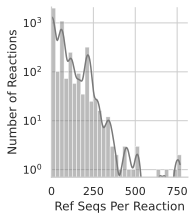

In [28]:
ax = sns.displot(x=gene_counts, kde=True, binwidth=25, color=muted[7], height=3, aspect=1,
            log_scale=(False, True))
ax.set(xlim=(0))
ax.set(ylim=(.7,2100))
plt.xlabel('Ref Seqs Per Reaction')
plt.ylabel('Number of Reactions')

In [27]:
# Load reaction scores from diamond alignment to CarveMe Biochem function to sequence database
rxn_scores = pickle.load(open('carveme_rxn_scores.pickle','rb'))
# Adjust reaction IDs to match IDs in Universal Model
list(rxn_scores['reaction'])[0].replace('R_','')
# Make dictionary from reaction scores df
rxn_scores_dict = {}
for index, row in rxn_scores.iterrows():
    rxn_scores_dict[row['reaction'].replace('R_','')] = [row['bitscore']]
    
# Remove reaction scores for reactions that aren't in the universal model
missing_rxns_w_scores = []
rxn_scores_dict_alt = dict()
for key, val in rxn_scores_dict.items():
    try:
        universal_ML1515.reactions.get_by_id(key)
        rxn_scores_dict_alt[key] = val
    except:
        missing_rxns_w_scores.append(key)
len(missing_rxns_w_scores)

340

In [28]:
count_rxns = 0
for rxn in universal_ML1515.reactions:
    if rxn.id[0:3] not in ['EX_','SNK','Gro','sin','DM_','BIO','Bio']:
        if rxn.lower_bound > 0.0 or rxn.upper_bound > 0.0:
            count_rxns += 1
print(count_rxns)

3948


In [29]:
# Check no growth in condition without carbon source...
base_media = ['co2_e','fe3_e','h_e','mn2_e','fe2_e','zn2_e','mg2_e','ca2_e','ni2_e','cu2_e',
              'sel_e','cobalt2_e','h2o_e','mobd_e','k_e','na1_e','cl_e','tungs_e','slnt_e','o2_e']

rxn_weights_pfba = convert_to_weight_space(universal_ML1515, rxn_scores_dict_alt, pfba=True)
pfba_expr = write_dgFBA_expr(universal_ML1515, rxn_weights_pfba)

set_dgFBA_media(universal_ML1515, base_media)
solution = dgFBA(universal_ML1515, pfba_expr, 'Biomass') # BIOMASS_Ec_iML1515_core_75p37M

try:
    active_rxns = set([rxn.id for rxn in universal.reactions if abs(solution.fluxes[rxn.id]) > 1e-6])
    print(len(active_rxns))
    print(solution.fluxes['Biomass'])
except:
    print(solution)

0
0.0


In [30]:
print('Number of reactions in the Universal with Bit-scores:', len(rxn_scores_dict_alt))

all_vals = []
for val in rxn_scores_dict_alt.values():
    all_vals.append(val)

Number of reactions in the Universal with Bit-scores: 2662


Text(5.857929687499993, 0.5, 'Number of Reactions')

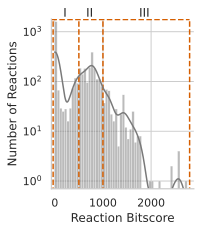

In [30]:
bit_score_vals = []
for rxn in universal_ML1515.reactions:
    if rxn.id[0:3] not in ['EX_','SNK','Gro','sin','DM_','BIO','Bio']:
        try:
            bit_score_vals.append(rxn_scores_dict_alt[rxn.id][0])
        except:
            bit_score_vals.append(0.0)
bit_score_vals.sort()
x = list(range(1, len(bit_score_vals)+1))

ax = sns.displot(x=bit_score_vals, kde=True, binwidth=50, color=muted[7], height=3, aspect=1,
            log_scale=(False, True))
ax.set(xlim=(-70))
ax.set(ylim=(.7,1800))
plt.vlines(-35, 0, 4000, linestyle='--', color=colors[3])
plt.vlines(500, 0, 4000, linestyle='--', color=colors[3])
plt.vlines(1000, 0, 4000, linestyle='--', color=colors[3])
plt.vlines(2800, 0, 4000, linestyle='--', color=colors[3])
plt.axhline(y=1760, xmin = 0, xmax=.97, linestyle='--', color=colors[3])
plt.text(175, 2000, 'I')
plt.text(650, 2000, 'II')
plt.text(1750, 2000, 'III')
plt.xlabel('Reaction Bitscore')
plt.ylabel('Number of Reactions')

In [31]:
rxn_weights = convert_to_weight_space(universal_ML1515, rxn_scores_dict_alt, compression=0.0)

In [32]:
rxn_fwd_weights = []
for val in rxn_weights.values():
    if val[0] > -1.0:
        rxn_fwd_weights.append(val[0])

Text(5.982929687499993, 0.5, 'Number of Reactions')

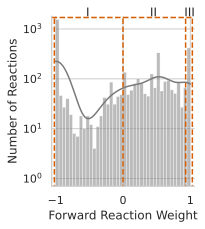

In [33]:
fwd_rxn_weights = []
for rxn in universal_ML1515.reactions:
    if rxn.id[0:3] not in ['EX_','SNK','Gro','sin','DM_','BIO','Bio']:
        try:
            fwd_rxn_weights.append(rxn_weights[rxn.id][0])
        except:
            fwd_rxn_weights.append(-1.0)
fwd_rxn_weights.sort()
x = list(range(1, len(fwd_rxn_weights)+1))

ax = sns.displot(x=fwd_rxn_weights, kde=True, binwidth=0.05, color=muted[7], height=3, aspect=1,
            log_scale=(False, True))
ax.set(xlim=(-1.06,1.06))
ax.set(ylim=(.7,1800))
plt.vlines(-1.02, 0, 1800, linestyle='--', color=colors[3])
plt.vlines(0, 0, 1800, linestyle='--', color=colors[3])
plt.vlines(0.93, 0, 1800, linestyle='--', color=colors[3])
plt.vlines(1.03, 0, 1800, linestyle='--', color=colors[3])

plt.axhline(y=1700, xmin = 0, xmax=.98, linestyle='--', color=colors[3])
plt.text(-.55, 1800, 'I')
plt.text(.4, 1800, 'II')
plt.text(.91, 1800, 'III')
plt.xlabel('Forward Reaction Weight')
plt.ylabel('Number of Reactions')

Text(5.857929687499993, 0.5, 'Number of Reactions')

<Figure size 216x216 with 0 Axes>

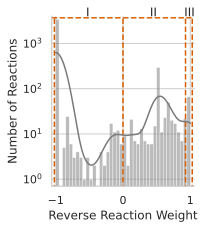

In [34]:
# Reverse Reaction Weights
rvs_rxn_weights = []
for rxn in universal_ML1515.reactions:
    if rxn.id[0:3] not in ['EX_','SNK','Gro','sin','DM_','BIO','Bio']:
        try:
            rvs_rxn_weights.append(rxn_weights[rxn.id][1])
        except:
            rvs_rxn_weights.append(-1.0)
rvs_rxn_weights.sort()
x = list(range(1, len(rvs_rxn_weights)+1))

plt.figure(figsize = (3, 3))

ax = sns.displot(x=rvs_rxn_weights, kde=True, binwidth=0.05, color=muted[7], height=3, aspect=1,
            log_scale=(False, True))
ax.set(xlim=(-1.06,1.06))
ax.set(ylim=(.7,4000))
plt.vlines(-1.02, 0, 4000, linestyle='--', color=colors[3])
plt.vlines(0, 0, 4000, linestyle='--', color=colors[3])
plt.vlines(0.93, 0, 4000, linestyle='--', color=colors[3])
plt.vlines(1.03, 0, 4000, linestyle='--', color=colors[3])

plt.axhline(y=3700, xmin = 0, xmax=.98, linestyle='--', color=colors[3])
plt.text(-.55, 4000, 'I')
plt.text(.4, 4000, 'II')
plt.text(.91, 4000, 'III')
plt.xlabel('Reverse Reaction Weight')
plt.ylabel('Number of Reactions')

In [33]:
universal_ML1515

<Model bigg_universe at 0x7f87f861bfd0>

In [34]:
# Remove SNK reactions from Universal Model
toRemove = []
for rxn in universal_ML1515.reactions:
    if rxn.id.startswith('SNK'):
        toRemove.append(rxn)
    elif rxn.id.startswith('BIOMASS_Ec'):
        toRemove.append(rxn)

print(len(toRemove))
universal_ML1515.remove_reactions(toRemove)

1879


In [81]:
# Make E.coli CANYUN using Universal_ML1515
t0 = time.time()
rxn_weights_ML1515 = convert_to_weight_space(universal_ML1515, rxn_scores_dict_alt, compression=0.0)
dgfba_expr_ML1515 = write_dgFBA_expr(universal_ML1515, rxn_weights_ML1515)
CANYUN_output = make_canyun(universal_ML1515, dgfba_expr_ML1515, well_id_media_dict_ML1515, 'Biomass')
CANYUN_usage_dict = make_usage_dict(universal_ML1515, CANYUN_output[4], gng_dict_long)
t1 = time.time()

total = t1-t0
print(str(total)+' Secounds')

print(len(CANYUN_output[0]))
print(len(CANYUN_output[1]))
print(len(CANYUN_output[2]))
print(len(CANYUN_output[3]))

feasible_media_conditions = dict()
for well_key in CANYUN_output[0]:
    feasible_media_conditions[well_key] = well_id_media_dict_ML1515[well_key]
print(len(feasible_media_conditions))
# CANYUN_output = [comp_growth, no_comp_growth, infeasible_list, error_list, solution_dict, active_rxn_dict]
# 265 and 8

256.1005902290344 Secounds
265
8
0
0
265


In [82]:
# Save down growth conditions for CarveMe model generation
growth_conditions = []
for key in CANYUN_output[0]:
    if gng_dict_long[key] > 0:
        growth_conditions.append(key)
print(len(growth_conditions))

# pickle.dump(growth_conditions, open('growth_condition_keys_for_carveme.pickle', 'wb'))
# pickle.dump(well_id_media_dict_ML1515, open('media_conditions_for_carveme_complete.pickle', 'wb'))

print(len(well_id_media_dict_ML1515))

196
273


In [83]:
# Matthews Corr Coef
from sklearn.metrics import matthews_corrcoef

def mcc_calc(output):
    y_true = []
    y_pred = []
    for key in output[0]:
        if gng_dict_long[key] > 0:
#             growth_tp+=1
            y_true.append(1)
            y_pred.append(1)
        elif gng_dict_long[key] == 0:
#             growth_fp+=1
            y_true.append(0)
            y_pred.append(1)
    for key in output[1]:
        if gng_dict_long[key] > 0:
#             growth_fn+=1
            y_true.append(1)
            y_pred.append(0)
        elif gng_dict_long[key] == 0:
#             growth_tn+=1
            y_true.append(0)
            y_pred.append(0)
    for key in output[2]:
        if gng_dict_long[key] > 0:
#             growth_INFg+=1
            y_true.append(1)
            y_pred.append(0)
        elif gng_dict_long[key] == 0:
#             growth_INFng+=1
            y_true.append(0)
            y_pred.append(0)
        
    return matthews_corrcoef(y_true, y_pred)

In [84]:
# Calculate Model accuracy
def calc_acc(output):
    growth_tp = 0
    growth_fp = 0
    growth_tn = 0
    growth_fn = 0
    growth_INFg = 0
    growth_INFng = 0

    for key in output[0]:
        if gng_dict_long[key] > 0:
            growth_tp+=1
        elif gng_dict_long[key] == 0:
            growth_fp+=1
    for key in output[1]:
        if gng_dict_long[key] > 0:
            growth_fn+=1
        elif gng_dict_long[key] == 0:
            growth_tn+=1
    for key in output[2]:
        if gng_dict_long[key] > 0:
            growth_INFg+=1
        elif gng_dict_long[key] == 0:
            growth_INFng+=1 
    acc = (growth_tp+growth_tn+growth_INFng)/(growth_tp+growth_tn+growth_INFng+growth_fp+growth_fn+growth_INFg)
    print('Accuracy:', (growth_tp+growth_tn+growth_INFng)/(growth_tp+growth_tn+growth_INFng+growth_fp+growth_fn+growth_INFg))
    print('True Pos', growth_tp)
    print('False Pos', growth_fp)
    print('True Neg', growth_tn)
    print('False Neg', growth_fn)
    print('-------------------')

    return(acc)

In [87]:
# Test if the used reactions make an accurate model

# Remove all reactions that don't have usage values
test_usage_model = deepcopy(universal_ML1515)

rxns_w_genes = []
for key, value in rxn_scores_dict_alt.items():
    if value[0] > 500:
        rxns_w_genes.append(key)

toRemove = []
for rxn in test_usage_model.reactions:
    if rxn.id[0:3] not in ['EX_','SNK','Gro','sin','DM_','BIO','Bio']: # and rxn.id not in rxns_w_genes: #  
        try:
            vals = CANYUN_usage_dict[rxn.id]
            if vals[0] == 0.0:
                rxn.upper_bound = 0.0
            if vals[1] == 0.0:
                rxn.lower_bound = 0.0
        except:
            toRemove.append(rxn)

test_usage_model.remove_reactions(toRemove)

t0 = time.time()
test_pfba_weights = convert_to_weight_space(test_usage_model, rxn_scores_dict_alt, pfba=True)
test_pfba_expr = write_dgFBA_expr(test_usage_model, test_pfba_weights)
test_output = make_canyun(test_usage_model, test_pfba_expr, well_id_media_dict_ML1515, 'Biomass')
t1 = time.time()

total = t1-t0
print(str(total)+' Secounds')

print(calc_acc(test_output))
print('MCC:', mcc_calc(test_output))

38.27624464035034 Secounds
Accuracy: 0.8021978021978022
True Pos 196
False Pos 51
True Neg 23
False Neg 3
-------------------
0.8021978021978022
MCC: 0.44782734700257054


In [42]:
196+51+23+3

273

In [40]:
# Calculate number of biolog conditions with growth data that can't be simulated with
growth = 0
no_growth = 0

for well_key in set(nan_wells + missing_e_met_keys): #  - set(duplicate_wells)
    try:
        if gng_dict[well_key][0] > 0.0: # Aerobic Growth
            growth += 1
        if gng_dict[well_key][1] > 0.0: # Anaerobic Growth
            growth += 1
        if gng_dict[well_key][0] == 0.0: # Aerobic No Growth
            no_growth += 1
        if gng_dict[well_key][1] == 0.0: # Anaerobic No Growth
            no_growth += 1
    except:
        pass
print('Growth Conditions:', growth)
print('No Growth Conditions:', no_growth)

Growth Conditions: 93
No Growth Conditions: 96


# Identify reactions essential for growth

In [46]:
# def extract_essential_rxn_ids(ess_rxns_df):
#     ess_rxn_list = []
#     ess_rxns_df_2 = ess_rxns_df.loc[(ess_rxns_df['growth'] < 1e-6)]
#     for rxn_set in ess_rxns_df_2.index.tolist():
#         rxn_id = list(rxn_set)[0]
#         if rxn_id[0:3] not in ['EX_','SNK','Gro','sin','DM_','BIO','Bio']:
#             ess_rxn_list.append(rxn_id)
#     return ess_rxn_list

In [43]:
# def find_f_essential_rxns(model, key, well_id_media_dict):

#     model_temp = deepcopy(model)

#     media_list = well_id_media_dict[key]
#     objective_rxn_id = 'Biomass'

#     set_dgFBA_media(model_temp, media_list)
#     essential_rxns = []
#     semi_essential_rxns = []
#     essential_rxns_r = []
#     essential_rxns_f = []

#     BM_rxn = model_temp.reactions.get_by_id(objective_rxn_id)
#     BM_rxn.lower_bound = 0.0
#     BM_rxn.upper_bound = 1000.0
#     fba_expr = BM_rxn.forward_variable
#     model_temp.objective = model_temp.problem.Objective(fba_expr, direction='max', sloppy=True)
#     model_temp.solver.update()
#     fba_optimum = model_temp.slim_optimize()
#     print(key, fba_optimum)

#     f_ess_rxns_df = single_reaction_deletion_fr('forward', model_temp)
#     f_ess_rxn_list = extract_essential_rxn_ids(f_ess_rxns_df)
    
#     return f_ess_rxn_list

In [44]:
# def find_r_essential_rxns(model, key, well_id_media_dict):

#     model_temp = deepcopy(model)

#     media_list = well_id_media_dict[key]
#     objective_rxn_id = 'Biomass'

#     set_dgFBA_media(model_temp, media_list)
#     essential_rxns = []
#     semi_essential_rxns = []
#     essential_rxns_r = []
#     essential_rxns_f = []

#     BM_rxn = model_temp.reactions.get_by_id(objective_rxn_id)
#     BM_rxn.lower_bound = 0.0
#     BM_rxn.upper_bound = 1000.0
#     fba_expr = BM_rxn.forward_variable
#     model_temp.objective = model_temp.problem.Objective(fba_expr, direction='max', sloppy=True)
#     model_temp.solver.update()
#     fba_optimum = model_temp.slim_optimize()
#     print(key, fba_optimum)

#     r_ess_rxns_df = single_reaction_deletion_fr('reverse', model_temp)
#     r_ess_rxn_list = extract_essential_rxn_ids(r_ess_rxns_df)
    
#     return r_ess_rxn_list

In [47]:
import datetime

# Test for uniquely essential reactions in the false positive conditions
fp_f_ess_dict = dict()

print("Start time:-", datetime.datetime.now())

for key in test_output[0]:
    if gng_dict_long[key] == 0:
        print('Started:', key, 'at', datetime.datetime.now())
        fp_essential_rxns_f = find_f_essential_rxns(test_usage_model, key, well_id_media_dict_ML1515)
        fp_f_ess_dict[key] = fp_essential_rxns_f
        
print("Finish time:-", datetime.datetime.now())

Start time:- 2021-07-20 20:59:25.553412
Started: PM1D4_1 at 2021-07-20 20:59:25.553644
PM1D4_1 16.24080538081669
Started: PM1D11_1 at 2021-07-20 20:59:28.818877
PM1D11_1 31.228370372926342
Started: PM1E9_1 at 2021-07-20 20:59:32.052479
PM1E9_1 0.5226149427801108
Started: PM1E9_0 at 2021-07-20 20:59:34.605641
PM1E9_0 0.5226149427800785
Started: PM1F2_1 at 2021-07-20 20:59:37.668408
PM1F2_1 24.89131035094916
Started: PM1F3_1 at 2021-07-20 20:59:40.989618
PM1F3_1 29.42652152943828
Started: PM1F11_1 at 2021-07-20 20:59:44.488713
PM1F11_1 0.5226149427801108
Started: PM1F11_0 at 2021-07-20 20:59:47.364770
PM1F11_0 0.5226149427800785
Started: PM1G2_1 at 2021-07-20 20:59:49.900467
PM1G2_1 0.5226149427801108
Started: PM1H2_1 at 2021-07-20 20:59:52.457538
PM1H2_1 15.946988314653934
Started: PM1H4_1 at 2021-07-20 20:59:56.048651
PM1H4_1 0.5226149427801108
Started: PM1H11_1 at 2021-07-20 20:59:58.530115
PM1H11_1 0.5226149427801108
Started: PM1H11_0 at 2021-07-20 21:00:01.027120
PM1H11_0 0.52261494

In [48]:
print(len(fp_f_ess_dict['PM1D4_1']))

165


In [49]:
# Test for uniquely essential reverse reactions in the false positive conditions
fp_r_ess_dict = dict()

print("Start time:-", datetime.datetime.now())

for key in test_output[0]:
    if gng_dict_long[key] == 0:
        print('Started:', key, 'at', datetime.datetime.now())
        fp_essential_rxns_r = find_r_essential_rxns(test_usage_model, key, well_id_media_dict_ML1515)
        fp_r_ess_dict[key] = fp_essential_rxns_r
        
print("Finish time:-", datetime.datetime.now())

Start time:- 2021-07-20 21:02:23.351781
Started: PM1D4_1 at 2021-07-20 21:02:23.352007
PM1D4_1 16.24080538081669
Started: PM1D11_1 at 2021-07-20 21:02:25.942407
PM1D11_1 31.228370372926342
Started: PM1E9_1 at 2021-07-20 21:02:29.364589
PM1E9_1 0.5226149427801108
Started: PM1E9_0 at 2021-07-20 21:02:31.821060
PM1E9_0 0.5226149427800785
Started: PM1F2_1 at 2021-07-20 21:02:34.425675
PM1F2_1 24.89131035094916
Started: PM1F3_1 at 2021-07-20 21:02:37.003321
PM1F3_1 29.42652152943828
Started: PM1F11_1 at 2021-07-20 21:02:39.644317
PM1F11_1 0.5226149427801108
Started: PM1F11_0 at 2021-07-20 21:02:42.918242
PM1F11_0 0.5226149427800785
Started: PM1G2_1 at 2021-07-20 21:02:45.389712
PM1G2_1 0.5226149427801108
Started: PM1H2_1 at 2021-07-20 21:02:47.776682
PM1H2_1 15.946988314653934
Started: PM1H4_1 at 2021-07-20 21:02:50.412917
PM1H4_1 0.5226149427801108
Started: PM1H11_1 at 2021-07-20 21:02:52.975232
PM1H11_1 0.5226149427801108
Started: PM1H11_0 at 2021-07-20 21:02:56.373988
PM1H11_0 0.52261494

In [50]:
# True positive Forward essential reactions
tp_f_ess_dict = dict()

for key in test_output[0]:
    if gng_dict_long[key] > 0 and key != 'PM1C11_0':
        print('Started:', key, 'at', datetime.datetime.now())
        tp_essential_rxns_f  = find_f_essential_rxns(test_usage_model, key, well_id_media_dict_ML1515)
        tp_f_ess_dict[key] = tp_essential_rxns_f
print("Finished: ", datetime.datetime.now())

Started: PM1A2_1 at 2021-07-20 21:05:36.894876
PM1A2_1 31.22837037293053
Started: PM1A2_0 at 2021-07-20 21:05:40.774729
PM1A2_0 18.93277257023642
Started: PM1A3_1 at 2021-07-20 21:05:44.972733
PM1A3_1 29.663559863106602
Started: PM1A3_0 at 2021-07-20 21:05:49.242870
PM1A3_0 19.690664813265773
Started: PM1A4_1 at 2021-07-20 21:05:53.349313
PM1A4_1 27.05301007227217
Started: PM1A4_0 at 2021-07-20 21:05:57.475401
PM1A4_0 14.875990452276861
Started: PM1A5_1 at 2021-07-20 21:06:00.942348
PM1A5_1 18.58338105700557
Started: PM1A5_0 at 2021-07-20 21:06:04.689984
PM1A5_0 2.1177588558116702
Started: PM1A6_1 at 2021-07-20 21:06:09.045446
PM1A6_1 31.22837037292691
Started: PM1A6_0 at 2021-07-20 21:06:13.073690
PM1A6_0 19.28154692095452
Started: PM1A7_1 at 2021-07-20 21:06:17.286580
PM1A7_1 18.76520204202205
Started: PM1A7_0 at 2021-07-20 21:06:21.117827
PM1A7_0 9.927484851222856
Started: PM1A8_1 at 2021-07-20 21:06:24.725157
PM1A8_1 21.009573276784216
Started: PM1A8_0 at 2021-07-20 21:06:29.349292

PM1G12_1 18.76520204206031
Started: PM1G12_0 at 2021-07-20 21:13:22.160081
PM1G12_0 7.53119540528753
Started: PM1H2_0 at 2021-07-20 21:13:26.033827
PM1H2_0 1.2224363406761407
Started: PM1H4_0 at 2021-07-20 21:13:29.586980
PM1H4_0 0.5226149427800785
Started: PM1H6_1 at 2021-07-20 21:13:33.535581
PM1H6_1 31.228370372927113
Started: PM1H6_0 at 2021-07-20 21:13:40.018376
PM1H6_0 18.93277257023472
Started: PM1H8_1 at 2021-07-20 21:13:45.003641
PM1H8_1 17.601864896463525
Started: PM1H8_0 at 2021-07-20 21:13:49.059693
PM1H8_0 8.732180784072503
Started: PM1H10_1 at 2021-07-20 21:13:52.892290
PM1H10_1 35.88528330024155
Started: PM1H10_0 at 2021-07-20 21:13:57.767983
PM1H10_0 22.147731471094666
Started: PM2AA6_1 at 2021-07-20 21:14:02.005401
PM2AA6_1 0.5226149427801108
Started: PM2AB2_1 at 2021-07-20 21:14:05.842477
PM2AB2_1 31.64645490036858
Started: PM2AB3_1 at 2021-07-20 21:14:10.772891
PM2AB3_1 24.853297638310668
Started: PM2AC9_1 at 2021-07-20 21:14:15.350112
PM2AC9_1 35.885283300263325
Sta

In [53]:
# True positive Reverse essential reactions
tp_r_ess_dict = dict()

for key in test_output[0]:
    if gng_dict_long[key] > 0 and key not in ['PM1C10_0','PM1C11_0']:
        print('Started:', key, 'at', datetime.datetime.now())
        tp_essential_rxns_r = find_r_essential_rxns(test_usage_model, key, well_id_media_dict_ML1515)
        tp_r_ess_dict[key] = tp_essential_rxns_r
print("Finished: ", datetime.datetime.now())

Started: PM1A2_1 at 2021-07-20 21:58:53.555907
PM1A2_1 31.22837037293053
Started: PM1A2_0 at 2021-07-20 21:58:58.086626
PM1A2_0 18.93277257023642
Started: PM1A3_1 at 2021-07-20 21:59:02.159106
PM1A3_1 29.663559863106602
Started: PM1A3_0 at 2021-07-20 21:59:06.690980
PM1A3_0 19.690664813265773
Started: PM1A4_1 at 2021-07-20 21:59:11.406619
PM1A4_1 27.05301007227217
Started: PM1A4_0 at 2021-07-20 21:59:15.929560
PM1A4_0 14.875990452276861
Started: PM1A5_1 at 2021-07-20 21:59:20.673607
PM1A5_1 18.58338105700557
Started: PM1A5_0 at 2021-07-20 21:59:24.624736
PM1A5_0 2.1177588558116702
Started: PM1A6_1 at 2021-07-20 21:59:28.865651
PM1A6_1 31.22837037292691
Started: PM1A6_0 at 2021-07-20 21:59:32.860497
PM1A6_0 19.28154692095452
Started: PM1A7_1 at 2021-07-20 21:59:37.433112
PM1A7_1 18.76520204202205
Started: PM1A7_0 at 2021-07-20 21:59:41.424504
PM1A7_0 9.927484851222856
Started: PM1A8_1 at 2021-07-20 21:59:45.469016
PM1A8_1 21.009573276784216
Started: PM1A8_0 at 2021-07-20 21:59:50.003128

PM1G12_0 7.53119540528753
Started: PM1H2_0 at 2021-07-20 22:07:31.997941
PM1H2_0 1.2224363406761407
Started: PM1H4_0 at 2021-07-20 22:07:37.117146
PM1H4_0 0.5226149427800785
Started: PM1H6_1 at 2021-07-20 22:07:41.901002
PM1H6_1 31.228370372927113
Started: PM1H6_0 at 2021-07-20 22:07:46.591566
PM1H6_0 18.93277257023472
Started: PM1H8_1 at 2021-07-20 22:07:51.487584
PM1H8_1 17.601864896463525
Started: PM1H8_0 at 2021-07-20 22:07:56.297171
PM1H8_0 8.732180784072503
Started: PM1H10_1 at 2021-07-20 22:08:01.215847
PM1H10_1 35.88528330024155
Started: PM1H10_0 at 2021-07-20 22:08:06.078993
PM1H10_0 22.147731471094666
Started: PM2AA6_1 at 2021-07-20 22:08:11.261572
PM2AA6_1 0.5226149427801108
Started: PM2AB2_1 at 2021-07-20 22:08:20.151608
PM2AB2_1 31.64645490036858
Started: PM2AB3_1 at 2021-07-20 22:08:24.927232
PM2AB3_1 24.853297638310668
Started: PM2AC9_1 at 2021-07-20 22:08:29.472809
PM2AC9_1 35.885283300263325
Started: PM2AE5_1 at 2021-07-20 22:08:34.131404
PM2AE5_1 31.22837037293193
Sta

In [54]:
from collections import Counter

# Reverse
fp_r_ess_set = set()
fp_r_ess_list = list()
for key, val in fp_r_ess_dict.items():
    fp_r_ess_set |= set(val)
    fp_r_ess_list = fp_r_ess_list + val

fp_r_ess_count = Counter(fp_r_ess_list)

tp_r_ess_set = set()
tp_r_ess_list = list()
for key, val in tp_r_ess_dict.items():
    tp_r_ess_set |= set(val)
    tp_r_ess_list = tp_r_ess_list + val

tp_r_ess_count = Counter(tp_r_ess_list)

colors_r = []
x_r = []
y_r =[]

for key, val in fp_r_ess_count.items():
    try:
        score_str = str(rxn_scores_dict_alt[key][0])
        score_temp = rxn_scores_dict_alt[key][0]
    except:
        score_str = 'nan'
        score_temp = 0.0
    try:
        if val > tp_r_ess_count[key] and val > 1:
#             colors_r.append(score_temp)
#             x_r.append(val)
            x_r.append(score_temp)
            y_r.append(val - tp_r_ess_count[key])
            print(key + '\tGE: '+ score_str + ':\tFP: ' + str(val) + ',\tTP: ' + str(tp_r_ess_count[key]))
    except:
#         colors_r.append(score_temp)
#         x_r.append(val)
        x_r.append(score_temp)
#         y_r.append(0)
        y_r.append(val)
        print(key + '\tGE: '+ score_str + ':\tFP: ' + str(val) + ',\tTP: 0')

PGMT	GE: 1080.5:	FP: 38,	TP: 12
TALA	GE: 627.1:	FP: 38,	TP: 7
TKT2	GE: 1359.7:	FP: 38,	TP: 7
TKT1	GE: 1359.7:	FP: 38,	TP: 7
RPE	GE: 446.4:	FP: 38,	TP: 7
INOSTO	GE: nan:	FP: 38,	TP: 15
PGI	GE: 1115.1:	FP: 38,	TP: 12
O2t	GE: 1.0:	FP: 37,	TP: 7


In [ ]:
# TKT2	GE: 1359.7:	FP: 38,	TP: 7
# PGMT	GE: 1080.5:	FP: 38,	TP: 12
# PGI	GE: 1115.1:	FP: 38,	TP: 12
# TKT1	GE: 1359.7:	FP: 38,	TP: 7
# RPE	GE: 446.4:	FP: 38,	TP: 7
# O2t	GE: 1.0:	FP: 37,	TP: 7
# INOSTO	GE: nan:	FP: 38,	TP: 15
# TALA	GE: 627.1:	FP: 38,	TP: 7

In [55]:
# Forward
fp_f_ess_set = set()
fp_f_ess_list = list()
for key, val in fp_f_ess_dict.items():
    fp_f_ess_set |= set(val)
    fp_f_ess_list = fp_f_ess_list + val

fp_f_ess_count = Counter(fp_f_ess_list)

tp_f_ess_set = set()
tp_f_ess_list = list()
for key, val in tp_f_ess_dict.items():
    tp_f_ess_set |= set(val)
    tp_f_ess_list = tp_f_ess_list + val

tp_f_ess_count = Counter(tp_f_ess_list)

x_f = []
y_f = []

for key, val in fp_f_ess_count.items():
    try:
        score_str = str(rxn_scores_dict_alt[key][0])
        score_temp = rxn_scores_dict_alt[key][0]
    except:
        score_str = 'nan'
        score_temp = 0.0
    try:
        if val > tp_f_ess_count[key] and val > 1: #  
            x_f.append(score_temp)
            y_f.append(val - tp_f_ess_count[key])
            print(key + '\tGE: '+ score_str + ':\tFP: ' + str(val) + ',\tTP: ' + str(tp_f_ess_count[key]))
    except:
        x_f.append(score_temp)
        y_f.append(val)
        print(key + '\tGE: '+ score_str +':\tFP: ' + str(val) + ',\tTP: 0')

SUCDi	GE: 519.325:	FP: 38,	TP: 11
PRUK	GE: 49.3:	FP: 38,	TP: 7
GLCAASE3	GE: 331.3:	FP: 38,	TP: 12
SUCCtex	GE: 767.7:	FP: 37,	TP: 16
SUCCt1pp	GE: nan:	FP: 37,	TP: 16
FUM	GE: 1108.2:	FP: 38,	TP: 13
GLCURT	GE: nan:	FP: 38,	TP: 12
CO2t	GE: 1.0:	FP: 37,	TP: 7
RBPC	GE: nan:	FP: 38,	TP: 7
UDPGD	GE: 687.2:	FP: 38,	TP: 12
MMSAD3	GE: nan:	FP: 38,	TP: 8
ATPS4rpp	GE: 492.8125:	FP: 39,	TP: 17
INSCR	GE: nan:	FP: 39,	TP: 14
GALUi	GE: 599.7:	FP: 38,	TP: 12
SUCCt2b	GE: 825.5:	FP: 37,	TP: 16


In [ ]:
# SUCCt2b	GE: 825.5:	FP: 37,	TP: 16
# UDPGD	GE: 687.2:	FP: 38,	TP: 12
# CO2t	GE: 1.0:	FP: 37,	TP: 7
# MMSAD3	GE: nan:	FP: 38,	TP: 8
# SUCDi	GE: 519.325:	FP: 38,	TP: 11
# SUCCt1pp	GE: nan:	FP: 37,	TP: 16
# GLCURT	GE: nan:	FP: 38,	TP: 12
# SUCCtex	GE: 767.7:	FP: 37,	TP: 16
# PRUK	GE: 49.3:	FP: 38,	TP: 7
# ATPS4rpp	GE: 492.8125:	FP: 39,	TP: 17
# GLCAASE3	GE: 331.3:	FP: 38,	TP: 12
# FUM	GE: 1108.2:	FP: 38,	TP: 13
# INSCR	GE: nan:	FP: 39,	TP: 14
# RBPC	GE: nan:	FP: 38,	TP: 7
# GALUi	GE: 599.7:	FP: 38,	TP: 12

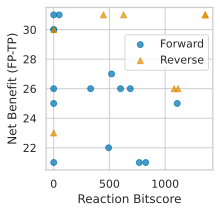

In [56]:
plt.figure(figsize = (3, 3))
plt.scatter(x_f, y_f, alpha=0.7)
plt.scatter(x_r, y_r, marker='^', alpha=0.7)
plt.xlabel('Reaction Bitscore')
plt.ylabel('Net Benefit (FP-TP)')
plt.legend(['Forward','Reverse'], frameon=True).set_bbox_to_anchor((.44, .58))
plt.show()

In [88]:
# Test if the used reactions make an accurate model

# Remove all reactions that don't have usage values
test_usage_model = deepcopy(universal_ML1515)

toRemove = []
for rxn in test_usage_model.reactions:
    if rxn.id in ['RBPC']: # Forward essential rxns
        rxn.upper_bound = 0.0
    
    if rxn.id[0:3] not in ['EX_','SNK','Gro','sin','DM_','BIO','Bio']: # and rxn.id not in rxns_w_genes: #  
        try:
            vals = CANYUN_usage_dict[rxn.id]
            if vals[0] == 0.0:
                rxn.upper_bound = 0.0
            if vals[1] == 0.0:
                rxn.lower_bound = 0.0
        except:
            toRemove.append(rxn)
        
test_usage_model.remove_reactions(toRemove)

t0 = time.time()
test_pfba_weights = convert_to_weight_space(test_usage_model, rxn_scores_dict_alt, pfba=True)
test_pfba_expr = write_dgFBA_expr(test_usage_model, test_pfba_weights)
test_output = make_canyun(test_usage_model, test_pfba_expr, well_id_media_dict_ML1515, 'Biomass')
t1 = time.time()

total = t1-t0
print(str(total)+' Secounds')

print(calc_acc(test_output))
print('MCC:', mcc_calc(test_output))

# 32.78590536117554 Secounds
# Accuracy: 0.9157509157509157
# True Pos 189
# False Pos 13
# True Neg 61
# False Neg 10
# -------------------
# 0.9157509157509157

33.85895252227783 Secounds
Accuracy: 0.9157509157509157
True Pos 189
False Pos 13
True Neg 61
False Neg 10
-------------------
0.9157509157509157
MCC: 0.784367330193771


In [42]:
# CANYUN_usage_dict = make_usage_dict(universal_ML1515, CANYUN_output[4], gng_dict_long)
# def make_usage_dict(model, solution_dict, gng_dict_long):

CANYUN_model_output_dict = {}
count = 0
for key, solution in CANYUN_output[4].items():
    if gng_dict_long[key] > 0.0:
        count += 1
        rxn_set = set([rxn.id for rxn in universal_ML1515.reactions if abs(solution.fluxes[rxn.id]) > 1e-6])
        for rxn_id in rxn_set:
            if solution.fluxes[rxn_id] > 1e-6: # Forward
                try:
                    CANYUN_model_output_dict[rxn_id] = [CANYUN_model_output_dict[rxn_id][0] + 1, CANYUN_model_output_dict[rxn_id][1]]
                except:
                    CANYUN_model_output_dict[rxn_id] = [1,0]
            elif solution.fluxes[rxn_id] < -1e-6: # Reverse
                try:
                    CANYUN_model_output_dict[rxn_id] = [CANYUN_model_output_dict[rxn_id][0], CANYUN_model_output_dict[rxn_id][1] + 1]
                except:
                    CANYUN_model_output_dict[rxn_id] = [0,1]
            else:
                print('ERROR')

# Adjust values to be ratios
for key, value in CANYUN_model_output_dict.items():
    CANYUN_model_output_dict[key] = [value[0]/count, value[1]/count]

In [43]:
print(len(CANYUN_model_output_dict))
print(len(CANYUN_usage_dict))

974
815


In [44]:
# Remove all reactions that don't have usage values
test_usage_model = deepcopy(universal_ML1515)

toRemove = []
for rxn in test_usage_model.reactions:
    if rxn.id in ['RBPC']: # Forward essential rxns
        toRemove.append(rxn)
    try:
        vals = CANYUN_model_output_dict[rxn.id]
        if vals[0] == 0.0:
            rxn.upper_bound = 0.0
        if vals[1] == 0.0:
            rxn.lower_bound = 0.0
    except:
        toRemove.append(rxn)

test_usage_model.remove_reactions(toRemove)

test_usage_model

<Model bigg_universe at 0x7f87ee0dbd00>

In [45]:
t0 = time.time()
test_pfba_weights = convert_to_weight_space(test_usage_model, rxn_scores_dict_alt, pfba=True)
test_pfba_expr = write_dgFBA_expr(test_usage_model, test_pfba_weights)
test_output = make_canyun(test_usage_model, test_pfba_expr, well_id_media_dict_ML1515, 'Biomass')
t1 = time.time()

total = t1-t0
print(str(total)+' Secounds')

calc_acc(test_output)

27.536120891571045 Secounds
Accuracy: 0.9157509157509157
True Pos 189
False Pos 13
True Neg 61
False Neg 10
-------------------


0.9157509157509157

In [46]:
media_list = well_id_media_dict_ML1515['PM1C1_1']
set_dgFBA_media(test_usage_model, media_list)

BM_rxn = test_usage_model.reactions.get_by_id('Biomass')
BM_rxn.lower_bound = 0.0
BM_rxn.upper_bound = 1000.0

fba_expr = BM_rxn.forward_variable + BM_rxn.reverse_variable
test_usage_model.objective = test_usage_model.problem.Objective(fba_expr, direction='max', sloppy=True)

test_usage_model.solver.update()

fba_solution = test_usage_model.optimize()
fba_opt = fba_solution.objective_value
print(fba_opt)

40.26499074916946


## REMOVE

In [47]:
# print(test_usage_model.reactions.get_by_id("CYSTabc").check_mass_balance())
# test_usage_model.reactions.get_by_id("CYSTabc")

In [48]:
# print(test_usage_model.metabolites.get_by_id("atp_c").formula)
# print(test_usage_model.metabolites.get_by_id("cyst__L_e").formula) # = 'C7H14N2O4S'
# print(test_usage_model.metabolites.get_by_id("h2o_c").formula)

# print(test_usage_model.metabolites.get_by_id("adp_c").formula)
# print(test_usage_model.metabolites.get_by_id("cyst__L_c").formula)
# print(test_usage_model.metabolites.get_by_id("h_c").formula)
# print(test_usage_model.metabolites.get_by_id("pi_c").formula)

In [49]:
# print(test_usage_model.reactions.get_by_id("MTHFR3").check_mass_balance())
# test_usage_model.reactions.get_by_id("MTHFR3")

In [50]:
# # print(test_usage_model.metabolites.get_by_id("atp_c").formula)
# print(test_usage_model.metabolites.get_by_id("mlthf_c").formula) # = 'C7H14N2O4S'
# print(test_usage_model.metabolites.get_by_id("nadph_c").formula)

# print(test_usage_model.metabolites.get_by_id("5mthf_c").formula)
# print(test_usage_model.metabolites.get_by_id("nadp_c").formula)

In [51]:
from cobra.io import save_json_model
m = test_usage_model
for rxn in m.reactions: rxn.annotation = {}
for met in m.metabolites: met.annotation = {}
for gene in m.genes: gene.annotation = {}
m.annotation = {}
save_json_model(m,'k12_canyun.json')

# CANYUN Dictionaries

In [135]:
# Make dictionary of CANYUNs
t0 = time.time()
compression_values = [0.0, 0.5, 0.9] 
thresholds = [200, 500, 700]
CANYUN_outputs = dict()
for thresh in thresholds:
    for comp in compression_values:
        rxn_weights = convert_to_weight_space(universal_ML1515, rxn_scores_dict_alt, compression=comp, threshold=thresh)
        dgfba_expr = write_dgFBA_expr(universal_ML1515, rxn_weights)
        CANYUN_output_temp = make_canyun(universal_ML1515, dgfba_expr, well_id_media_dict_ML1515, 'Biomass')
        CANYUN_outputs[str(thresh)+':'+str(comp)] = CANYUN_output_temp
        print(str(thresh)+':'+str(comp))
t1 = time.time()
print(str(t1-t0)+' Secounds')

200:0.0
200:0.5
200:0.9
500:0.0
500:0.5
500:0.9
700:0.0
700:0.5
700:0.9
1602.8913502693176 Secounds


In [52]:
# Make dictionary of CANYUNs using less genetic information
rxn_scores_dict_list = []
# print(len(rxn_scores_dict_alt))
for x in [0.0, 1.0]: # 0.2, 0.4, 0.6, 0.8,
    if x == 0.0:
        rxn_scores_dict_list.append(rxn_scores_dict_alt)
    else:
        random.seed(42)
        rxn_scores_dict_temp = dict(random.sample(rxn_scores_dict_alt.items(), round(x*len(rxn_scores_dict_alt))))
        rxn_scores_dict_list.append(rxn_scores_dict_temp)

t0 = time.time()
print('Starting Loop')
CANYUN_outputs_subset_scores = dict()
for y, rxn_scores_dict_temp in zip(['0','100'],rxn_scores_dict_list): # '20','40','60','80',
    if y == '0': # Run pFBA rather than dgFBA with no genetic data
        rxn_weights_ML1515 = convert_to_weight_space(universal_ML1515, rxn_scores_dict_temp, pfba = True)
    else: # With any amount of genetic data, run dgFBA
        rxn_weights_ML1515 = convert_to_weight_space(universal_ML1515, rxn_scores_dict_temp, compression=0.0, threshold=500)
    dgfba_expr_ML1515 = write_dgFBA_expr(universal_ML1515, rxn_weights_ML1515)
    output_ML1515_temp = make_canyun(universal_ML1515, dgfba_expr_ML1515, well_id_media_dict_ML1515, 'Biomass') # ML1515_media_conditions
    CANYUN_outputs_subset_scores[y] = output_ML1515_temp
    print(y)
t1 = time.time()
print(str(t1-t0)+' Secounds')

Starting Loop
0
100
447.93101477622986 Secounds


In [53]:
# CANYUN Rarefaction Curve of Unique Reactions with certainty value greater than zero
def CANYUN_rarefaction(model, output_x, gng_dict_long):
    # Make list of active reaction sets
    rxn_set_list = []
    for key, solution in output_x[4].items():
        if gng_dict_long[key] > 0.0:
            rxn_set = set([rxn.id for rxn in model.reactions if abs(solution.fluxes[rxn.id]) > 1e-6])
            rxn_set_list.append(rxn_set)

    # Merge Sets to determine curves
    count = 0
    rxn_num_lists = []
    index_list = [*range(len(rxn_set_list))]
    while count < 100:
        cum_rxn_set = set()
        random.shuffle(index_list)
        rxn_num_list = []
        for index in index_list:
            cum_rxn_set = cum_rxn_set | rxn_set_list[index]
            rxn_num_list.append(len(cum_rxn_set))
        rxn_num_lists.append(rxn_num_list)
        count +=1

    # Make min, mean, and max lists to plot
    min_list = []
    mean_list = []
    max_list = []
    for index in [*range(len(rxn_num_lists[0]))]:
        temp_list = []
        for rxn_num_list in rxn_num_lists:
            temp_list.append(rxn_num_list[index])
        min_list.append(min(temp_list))
        mean_list.append(statistics.mean(temp_list))
        max_list.append(max(temp_list))

    # Plot output
    x = range(1,len(rxn_num_lists[0])+1)
    
    return([x, mean_list, max_list, min_list])

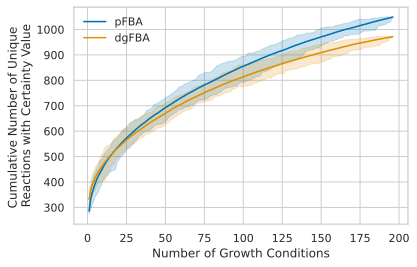

In [54]:
# Rarefaction curves for CANYUNs and pFBA unique reactions included in differing orders
data1 = CANYUN_rarefaction(universal_ML1515, CANYUN_outputs_subset_scores['100'], gng_dict_long)
data2 = CANYUN_rarefaction(universal_ML1515, CANYUN_outputs_subset_scores['0'], gng_dict_long)

palette = sns.color_palette()

plt.plot(data2[0],data2[1],color=colors[0],label='pFBA')
plt.fill_between(data2[0], data2[1], data2[2], alpha=.2, color=colors[0])
plt.fill_between(data2[0], data2[1], data2[3], alpha=.2, color=colors[0])

plt.plot(data1[0],data1[1],color=palette[1],label='dgFBA')
plt.fill_between(data1[0], data1[1], data1[2], alpha=.2, color=colors[1])
plt.fill_between(data1[0], data1[1], data1[3], alpha=.2, color=colors[1])

plt.xlabel('Number of Growth Conditions')
plt.ylabel('Cumulative Number of Unique \nReactions with Certainty Value')
plt.legend()

# plt.savefig('figure.png', bbox_inches='tight')
plt.show()

/home/tjmoutinho/canyuns/canyuns/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


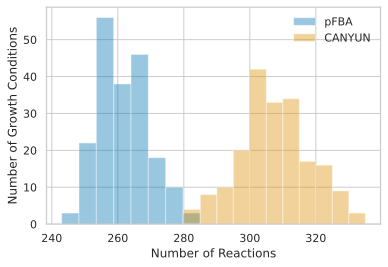

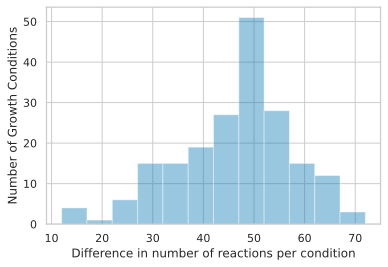

In [55]:
# Check to see if dgFBA breaks Parsimony
CANYUN_output = CANYUN_outputs_subset_scores['100']
CANYUN_output_pfba = CANYUN_outputs_subset_scores['0']

plt.figure(figsize = (6, 4))

growth_keys = []
for key, gng in gng_dict_long.items():
    if gng > 0.0 and key in CANYUN_output[4].keys():
        growth_keys.append(key)

var_num_0 = []
for key, solution in CANYUN_output_pfba[4].items():
    if gng_dict_long[key] > 0.0:
        active_rxns = []
        for rxn in universal_ML1515.reactions:
            if rxn.id[0:3] not in ['EX_','SNK','Gro','sin','DM_','BIO','Bio'] and abs(solution.fluxes[rxn.id]) > 1e-6:
                active_rxns.append(rxn.id)
        var_num_0.append(len(active_rxns))

bin_num = round((max(var_num_0) - min(var_num_0))/5)
sns.distplot(var_num_0, bins=bin_num, kde=False, hist=True, label="pFBA")

var_num_1 = []
for key, solution in CANYUN_output[4].items():
    if gng_dict_long[key] > 0.0:
        active_rxns = []
        for rxn in universal_ML1515.reactions:
            if rxn.id[0:3] not in ['EX_','SNK','Gro','sin','DM_','BIO','Bio'] and gng_dict_long[key] > 0.0 and abs(solution.fluxes[rxn.id]) > 1e-6:
                active_rxns.append(rxn.id)
        var_num_1.append(len(active_rxns))

bin_num = round((max(var_num_1) - min(var_num_1))/5)
sns.distplot(var_num_1, bins=bin_num, kde=False, hist=True, label="CANYUN")

plt.xlabel('Number of Reactions')
plt.ylabel('Number of Growth Conditions')
plt.legend()
plt.show()

# Difference Plot
%config InlineBackend.figure_format = 'svg'
plt.figure(figsize = (6, 4))

var_num =  [var_num_1i - var_num_0i for var_num_1i, var_num_0i in zip(var_num_1, var_num_0)]
bin_num = round((max(var_num) - min(var_num))/5)
sns.distplot(var_num, bins=bin_num, kde=False, hist=True) # , label="Condition Specific Difference"
plt.xlabel('Difference in number of reactions per condition')
plt.ylabel('Number of Growth Conditions')

# plt.legend()
plt.show()

Text(0.5, 0, '')

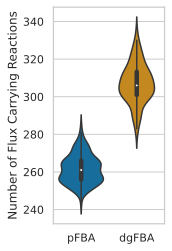

In [56]:
df = pd.DataFrame(list(zip(var_num_0, var_num_1)), 
               columns =['pFBA', 'dgFBA']) 
df = pd.melt(df, value_vars=['pFBA', 'dgFBA'], var_name='method', value_name='rxns')
# df
plt.figure(figsize = (2, 4))
# sns.set_theme(style="whitegrid")
ax = sns.violinplot(data=df, x="method", y="rxns") #, 
               #inner="quart", linewidth=1)
plt.ylabel('Number of Flux Carrying Reactions')
plt.xlabel('')

Text(0.5, 0, '')

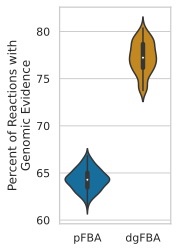

In [57]:
CANYUN_output = CANYUN_outputs_subset_scores['100']
CANYUN_output_pfba = CANYUN_outputs_subset_scores['0']

pfba_percents = []
for key, solution in CANYUN_output_pfba[4].items():
    if gng_dict_long[key] > 0.0:
        active_rxns = []
        rxns_w_evidence = []
        for rxn in universal_ML1515.reactions:
            if rxn.id[0:3] not in ['EX_','SNK','Gro','sin','DM_','BIO','Bio'] and abs(solution.fluxes[rxn.id]) > 1e-6:
                active_rxns.append(rxn.id)
                try:
                    if rxn_scores_dict_alt[rxn.id][0] >= 500:
                        rxns_w_evidence.append(rxn.id)
                except:
                    continue
        pfba_percents.append(100*len(rxns_w_evidence)/len(active_rxns))

dgfba_percents = []
for key, solution in CANYUN_output[4].items():
    if gng_dict_long[key] > 0.0:
        active_rxns = []
        rxns_w_evidence = []
        for rxn in universal_ML1515.reactions:
            if rxn.id[0:3] not in ['EX_','SNK','Gro','sin','DM_','BIO','Bio'] and gng_dict_long[key] > 0.0 and abs(solution.fluxes[rxn.id]) > 1e-6:
                active_rxns.append(rxn.id)
                try:
                    if rxn_scores_dict_alt[rxn.id][0] >= 500:
                        rxns_w_evidence.append(rxn.id)
                except:
                    continue
        dgfba_percents.append(100*len(rxns_w_evidence)/len(active_rxns))

df = pd.DataFrame(list(zip(pfba_percents, dgfba_percents)), 
               columns =['pFBA', 'dgFBA']) 
df = pd.melt(df, value_vars=['pFBA', 'dgFBA'], var_name='method', value_name='rxns')
# df
plt.figure(figsize = (2, 4))
# sns.set_theme(style="whitegrid")
sns.violinplot(data=df, x="method", y="rxns") #, 
               #inner="quart", linewidth=1)
plt.ylabel('Percent of Reactions with\nGenomic Evidence')
plt.xlabel('')

In [58]:
# Growth conditions
count = 0
for key in list(feasible_media_conditions.keys()):
    if gng_dict_long[key] > 0.0:
        count += 1
print(count)

196


In [168]:
# Prep for CarveMe Cross-validation
# pickle.dump(universal_ML1515, open('universal_for_carveme.pickle', 'wb'))
# pickle.dump(training_keys_list, open('training_wells_for_carveme.pickle', 'wb'))
# pickle.dump(testing_keys_list, open('testing_wells_for_carveme.pickle', 'wb'))
# pickle.dump(feasible_media_conditions, open('media_conditions_for_carveme.pickle', 'wb'))
# pickle.dump(gng_dict_long, open('gng_dict_for_carveme.pickle', 'wb'))
# BIOMASS_Ec_iML1515_core_75p37M

# ML1515

In [59]:
# Load iML1515 and add additional exchange reactions
ML1515_exs = cobra.io.load_json_model('iML1515.json')

met_id_list = []
for media_list in feasible_media_conditions.values():
    for met in media_list:
        # Search for exchange reactions
        try:
            temp_exchange = ML1515_exs.reactions.get_by_id('EX_'+ met)
        except:
            met_id_list.append(met)
met_id_set = set(met_id_list)
print(len(met_id_set))

# Add missing exchanges to ML1515
for met_id in met_id_set:
    try:
        ex_rxn = Reaction('EX_' + met_id)
        ex_rxn.name = "Exchange reaction for " + met_id
        ex_rxn.lower_bound = 0.0
        ex_rxn.upper_bound = 1000.0
        met = deepcopy(universal_ML1515.metabolites.get_by_id(met_id))
        ex_rxn.add_metabolites({met:-1})
        ML1515_exs.add_reactions([ex_rxn])
    except:
        print('ERROR:', met_id)

35


In [60]:
# Number of reactions in ML1515 that have genetic evidence associated with them in our database
print('Reactions with Genetic Evidence in our Database:', len(rxn_scores_dict_alt))
ML1515_rxn_list = []
for rxn in ML1515_exs.reactions:
#     if not rxn.id.startswith('EX') or not rxn.id.startswith('SINK') or not rxn.id.startswith('BIO'):
    if rxn.id[0:3] not in ['EX_','SNK','Gro','sin','DM_','BIO','Bio']:
        ML1515_rxn_list.append(rxn.id)
print('Biochemical reactions in ML1515:', len(ML1515_rxn_list))

count1 = 0
count2 = 0
count3 = 0
count4 = 0
var_num_0 = []
var_num_1 = []

for rxn in universal_ML1515.reactions:
    if rxn.id[0:3] not in ['EX_','SNK','Gro','sin','DM_','BIO','Bio']:
    #     print(rxn_id)
    #     print(val[0])
        if rxn.id in set(ML1515_rxn_list) and rxn.id in rxn_scores_dict_alt.keys():
            var_num_0.append(rxn_scores_dict_alt[rxn.id][0])
            count1 += 1
        if rxn.id not in set(ML1515_rxn_list) and rxn.id in rxn_scores_dict_alt.keys():
            var_num_1.append(rxn_scores_dict_alt[rxn.id][0])
            count2 += 1
        if rxn.id in set(ML1515_rxn_list) and rxn.id not in rxn_scores_dict_alt.keys():
            var_num_0.append(-100)
            count3 += 1
        if rxn.id not in set(ML1515_rxn_list) and rxn.id not in rxn_scores_dict_alt.keys():
            var_num_1.append(-100)
            count4 += 1

print('Biochemical reactions with Genetic Evidence in iML1515:', count1)
print('Biochemical reactions with Genetic Evidence NOT in iML1515:', count2)
print('Biochemical reactions without Genetic Evidence in iML1515:', count3)
print('Biochemical reactions without Genetic Evidence NOT in iML1515:', count4)

# %config InlineBackend.figure_format = 'svg'
# plt.figure(figsize = (6, 4))

# bin_num = round((max(var_num_0) - min(var_num_0))/100)
# sns.distplot(var_num_0, bins=bin_num, kde=False, hist=True, label="In iML1515")

# bin_num = round((max(var_num_1) - min(var_num_1))/100)
# sns.distplot(var_num_1, bins=bin_num, kde=False, hist=True, label="Not in iML1515")

# plt.xlabel('Reaction Bitscore')
# plt.ylabel('Number of Reactions')

# plt.legend()

Reactions with Genetic Evidence in our Database: 2662
Biochemical reactions in ML1515: 2373
Biochemical reactions with Genetic Evidence in iML1515: 2090
Biochemical reactions with Genetic Evidence NOT in iML1515: 572
Biochemical reactions without Genetic Evidence in iML1515: 283
Biochemical reactions without Genetic Evidence NOT in iML1515: 1195


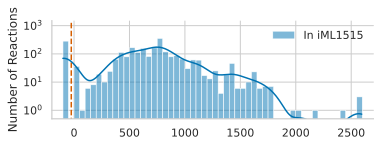

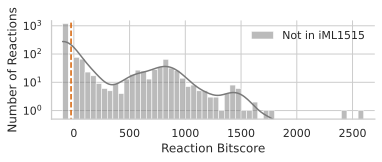

In [61]:
ax = sns.displot(x=var_num_0, kde=True, binwidth=50, color=colors[0], height=2, aspect=2.75,
            log_scale=(False, True), label="In iML1515")
ax.set(xlim=(-200,2700))
ax.set(ylim=(.5,1500))
plt.vlines(-25, 0, 1500, linestyle='--', color=colors[3])
plt.ylabel('Number of Reactions')
plt.yticks((1, 10, 100, 1000))
plt.legend()

ax2 = sns.displot(x=var_num_1, kde=True, binwidth=50, color=muted[7], height=2, aspect=2.8,
            log_scale=(False, True), label="Not in iML1515")
ax2.set(xlim=(-200,2700))
ax2.set(ylim=(.5,1500))
plt.vlines(-25, 0, 1500, linestyle='--', color=colors[3])
plt.yticks((1, 10, 100, 1000))

plt.xlabel('Reaction Bitscore')
plt.ylabel('Number of Reactions')

plt.legend()

In [62]:
# New Biomass Rxn

bm_rxn = Reaction('Biomass')
bm_rxn.name = "Custom Biomass for CANYUNs"
bm_rxn.lower_bound = 0.0
bm_rxn.upper_bound = 1000.0

extra_metabolites = ['kdo2lipid4_e', 'udcpdp_c', 'murein5px4p_p', 'btn_c', 'pe161_p', 
                     'pe160_p', 'sheme_c', '2fe2s_c', '4fe4s_c', 'pheme_c']

met_dict = dict()
old_met_dict = ML1515_exs.reactions.get_by_id('BIOMASS_Ec_iML1515_core_75p37M').metabolites
# old_met_dict2 = universal_ML1515.reactions.get_by_id('Growth').metabolites

for met in old_met_dict.keys():
    if met.id not in extra_metabolites:
#         met = ML1515_exs.metabolites.get_by_id(met2.id)
        met_dict[met] = old_met_dict[met]

bm_rxn.add_metabolites(met_dict)

ML1515_exs.add_reactions([bm_rxn])

ML1515_exs.reactions.get_by_id('BIOMASS_Ec_iML1515_core_75p37M').lower_bound = 0
ML1515_exs.reactions.get_by_id('BIOMASS_Ec_iML1515_core_75p37M').upper_bound = 0

ML1515_exs.reactions.get_by_id('ATPM').lower_bound = 0.0

In [63]:
# dgFBA with ML1515_exs

t0 = time.time()
rxn_scores_dict_alt_ML1515 = dict()
for rxn_id in [rxn.id for rxn in ML1515_exs.reactions]:
    try:
        rxn_scores_dict_alt_ML1515[rxn_id] = rxn_scores_dict_alt[rxn_id]
    except:
        pass

# ML1515_exs.add_reactions([universal.reactions.get_by_id('Growth')])

ML1515_weights = convert_to_weight_space(ML1515_exs, rxn_scores_dict_alt_ML1515, compression = 0.0) # , pfba=True
ML1515_expr = write_dgFBA_expr(ML1515_exs, ML1515_weights)
ML1515_output = make_canyun(ML1515_exs, ML1515_expr, well_id_media_dict_ML1515, 'Biomass') 
                                    # feasible_media_conditions , ML1515_media_conditions
ML1515_usage_dict = make_usage_dict(ML1515_exs, ML1515_output[4], gng_dict_long)
t1 = time.time()

total = t1-t0
print(str(total)+' Secounds')


74.24611949920654 Secounds


# Load in CarveMe Model

In [64]:
gapfilled_carve = cobra.io.read_sbml_model('completeGapfilledEcoliModel.xml')

# Compare CarveMe to iML1515
rxn_list = []
for rxn in gapfilled_carve.reactions:
    if not rxn.id.startswith('EX') and not rxn.id.startswith('SNK') and not rxn.id.startswith('Growth'):
        rxn_list.append(rxn.id)
cm_rxn_set = set(rxn_list)

rxn_list = []
for rxn in ML1515_exs.reactions:
    if not rxn.id.startswith('EX') and not rxn.id.startswith('SNK') and not rxn.id.startswith('Growth'):
        rxn_list.append(rxn.id)
ml1515_rxn_set = set(rxn_list)

print('Reactions in both:', len(cm_rxn_set & ml1515_rxn_set))
print('Extra reactions in CarveMe:', len(cm_rxn_set) - len(cm_rxn_set & ml1515_rxn_set))
print('Extra reactions in iML1515:', len(ml1515_rxn_set) - len(cm_rxn_set & ml1515_rxn_set))

# dgFBA with CarveMe Model using all of the media conditions
gapfilled_carve_exs = add_exs(gapfilled_carve, universal_ML1515, feasible_media_conditions)

t0 = time.time()
CM_weights = convert_to_weight_space(gapfilled_carve_exs, rxn_scores_dict_alt) # , pfba=True
CM_expr = write_dgFBA_expr(gapfilled_carve_exs, CM_weights)
CM_output = make_canyun(gapfilled_carve_exs, CM_expr, well_id_media_dict_ML1515, 'Biomass')
                                # feasible_media_conditions,
CM_usage_dict = make_usage_dict(gapfilled_carve_exs, CM_output[4], gng_dict_long)
t1 = time.time()

total = t1-t0
print(str(total)+' Secounds')

calc_acc(CM_output)

# Calculate CarveMe Discovery and Confirmation
gene_rxn_ids = []
for rxn in gapfilled_carve.reactions:
    if len(rxn.gene_reaction_rule) > 0:
        gene_rxn_ids.append(rxn.id)

ML_rxn_ids = [rxn.id for rxn in ML1515_exs.reactions]
true_confirmed_rxns = []
true_discovered_rxns = []
false_confirmed_rxns = []
false_discovered_rxns = []
for rxn in gapfilled_carve.reactions:
    if rxn.id[0:3] not in ['EX_','SNK','Gro','sin','DM_','BIO','Bio']:
        if rxn.id in ML_rxn_ids:
            if rxn.id in gene_rxn_ids:
                true_confirmed_rxns.append(rxn.id)
            elif rxn.id not in gene_rxn_ids:
                true_discovered_rxns.append(rxn.id)
        elif rxn.id not in ML_rxn_ids:
            if rxn.id in gene_rxn_ids:
                false_confirmed_rxns.append(rxn.id)
            elif rxn.id not in gene_rxn_ids:
                false_discovered_rxns.append(rxn.id)

print('T con', len(true_confirmed_rxns))
print('T dis', len(true_discovered_rxns))
print('F con', len(false_confirmed_rxns))
print('F dis', len(false_discovered_rxns))
# print('Missing w/ gene', len(missed_rxns_w_gene))
# print('Missing wo/ gene', len(missed_rxns_wo_gene))
total_num_reactions = (len(true_confirmed_rxns)+len(false_confirmed_rxns)+len(true_discovered_rxns)+len(false_discovered_rxns))
print('Total Discovered reactions',len(true_discovered_rxns)+len(false_discovered_rxns))
print('Discovery Acc', len(true_discovered_rxns)/(len(true_discovered_rxns)+len(false_discovered_rxns)))
print('Overlap with ML1515', (len(true_confirmed_rxns)+len(true_discovered_rxns))/total_num_reactions)

cm_total_num_discovered = len(true_discovered_rxns)+len(false_discovered_rxns)
cm_discovered_acc = len(true_discovered_rxns)/(len(true_discovered_rxns)+len(false_discovered_rxns))
cm_overlap = (len(true_confirmed_rxns)+len(true_discovered_rxns))/total_num_reactions

Reactions in both: 1961
Extra reactions in CarveMe: 614
Extra reactions in iML1515: 421
Exchanges add: 17
96.0779709815979 Secounds
Accuracy: 0.7619047619047619
True Pos 196
False Pos 62
True Neg 12
False Neg 3
-------------------
T con 1919
T dis 41
F con 511
F dis 96
Total Discovered reactions 137
Discovery Acc 0.29927007299270075
Overlap with ML1515 0.7635372029606544


In [91]:
mcc_calc(CM_output)

0.28691983453574965

In [175]:
# # Make dictionary of ML1515 dgFBA solutions
# t0 = time.time()
# rxn_scores_dict_alt_ML1515 = dict()
# for rxn_id in [rxn.id for rxn in ML1515_exs.reactions]:
#     try:
#         rxn_scores_dict_alt_ML1515[rxn_id] = rxn_scores_dict_alt[rxn_id]
#     except:
#         pass

# t0 = time.time()
# compression_values = [0.0, 0.5, 0.9] 
# thresholds = [200, 500, 700]
# ML1515_outputs = dict()
# for thresh in thresholds:
#     for comp in compression_values:
#         ML1515_dgFBA_weights = convert_to_weight_space(ML1515_exs, rxn_scores_dict_alt_ML1515, 
#                                                        compression=comp, threshold=thresh)
#         ML1515_dgfba_expr = write_dgFBA_expr(ML1515_exs, ML1515_dgFBA_weights)
#         ML1515_output_temp = make_canyun(ML1515_exs, ML1515_dgfba_expr, well_id_media_dict_ML1515, 'Biomass')
# #         usage_dict_ML1515 = make_usage_dict(universal_ML1515, output_ML1515[4], gng_dict_long)
#         ML1515_outputs[str(thresh)+':'+str(comp)] = ML1515_output_temp
#         print(str(thresh)+':'+str(comp))
# t1 = time.time()
# print(str(t1-t0)+' Secounds')

200:0.0
200:0.5
200:0.9
500:0.0
500:0.5
500:0.9
700:0.0
700:0.5
700:0.9
530.8981709480286 Secounds


In [65]:
# ML1515 Growth Prediction Accuracy
calc_acc(ML1515_output)

Accuracy: 0.7472527472527473
True Pos 158
False Pos 28
True Neg 46
False Neg 41
-------------------


0.7472527472527473

In [89]:
print('MCC:', mcc_calc(ML1515_output))

MCC: 0.3964541110579083


In [185]:
# # Compare CANYUNs to ML1515
# t0 = time.time()
# compression_values = [0.0, 0.5, 0.9] 
# thresholds = [200, 500, 700]
# for thresh in thresholds:
#     for comp in compression_values:
#         key = str(thresh)+':'+str(comp)
# #         temp_usage_dict = usage_dicts[key]
#         CANYUN_output_temp = CANYUN_outputs[key]
#         ML1515_output_temp = ML1515_outputs[key]
#         print(str(thresh)+':'+str(comp))
#         discovery_acc(ML1515_exs, ML1515_output_temp, universal_ML1515, CANYUN_output_temp)
#         print('-----------------------')
# t1 = time.time()
# print(str(t1-t0)+' Secounds')

200:0.0
Number of ML1515 Growth Conditions 189
Threshold set to: 0.0
Confirmed ML1515 reactions with Gene evidence: 509
True discovery without Gene evidence: 113
Reactions used with genetic evidence, but not in ML1515: 129
False discovery without Gene evidence: 90
Discovery without Gene Evidence Accuracy: 0.5566502463054187
622 out of 841 are true. 73.96 %
-----------------------
200:0.5
Number of ML1515 Growth Conditions 189
Threshold set to: 0.0
Confirmed ML1515 reactions with Gene evidence: 515
True discovery without Gene evidence: 113
Reactions used with genetic evidence, but not in ML1515: 129
False discovery without Gene evidence: 91
Discovery without Gene Evidence Accuracy: 0.553921568627451
628 out of 848 are true. 74.06 %
-----------------------
200:0.9
Number of ML1515 Growth Conditions 189
Threshold set to: 0.0
Confirmed ML1515 reactions with Gene evidence: 540
True discovery without Gene evidence: 119
Reactions used with genetic evidence, but not in ML1515: 135
False discov

In [66]:
def discovery_acc(ML1515_exs, ML1515_output, universal_ML1515, CANYUN_output, thresh = 0.0):
    # Real CANYUN
    CANYUN_usage_dict_alt = make_usage_dict(universal_ML1515, CANYUN_output[4], gng_dict_long)
    count_growth = 0
    for key in CANYUN_output[4].keys():
        if gng_dict_long[key] > 0:
            count_growth += 1
    
    print('Number of ML1515 Growth Conditions', count_growth)

    true_pos = []
    false_pos = []

    for rxn_id in CANYUN_usage_dict_alt.keys():
        if rxn_id[0:3] not in ['EX_','SNK','Gro','sin','DM_','BIO','Bio']:
            try:
                ML1515_exs.reactions.get_by_id(rxn_id)
                true_pos.append(rxn_id)
            except:
                false_pos.append(rxn_id)

    # print('Overall accuracy:', len(true_pos)/len(usage_dict_ML1515_alt))
    # print(len(false_pos)/len(usage_dict_ML1515))

    # Enzyme discovery
    count_false = 0
    count_true = 0
    threshold = thresh
    print('Threshold set to:', threshold)

    false_usage_vals = []
    imp_false = []
    for rxn_id in false_pos:
        usage_value = CANYUN_usage_dict_alt[rxn_id][0] + CANYUN_usage_dict_alt[rxn_id][1]
        false_usage_vals.append(usage_value)
        if usage_value > threshold:
            count_false += 1
            imp_false.append(rxn_id)

    true_usage_vals = []
    imp_true = []
    for rxn_id in true_pos:
        usage_value = CANYUN_usage_dict_alt[rxn_id][0] + CANYUN_usage_dict_alt[rxn_id][1]
        true_usage_vals.append(usage_value)
        if usage_value > threshold:
            count_true += 1
            imp_true.append(rxn_id)


    # Number of reactions with Usage Value in ML1515 and have low or no genetic evidence in our database
    confirmed_rxns = []
    discovered_wo_gene_rxns = []
    for rxn_id in imp_true: # Important true rxn ids are in ML1515
        try:
            if rxn_scores_dict_alt[rxn_id][0] > 500:
                confirmed_rxns.append(rxn_id)
            else:
                discovered_wo_gene_rxns.append(rxn_id)
        except:
            discovered_wo_gene_rxns.append(rxn_id)
    print('Confirmed ML1515 reactions with Gene evidence:', len(confirmed_rxns))
    print('True discovery without Gene evidence:', len(discovered_wo_gene_rxns))

    false_confirmed_rxns = []
    false_discovered_wo_gene_rxns = []
    for rxn_id in imp_false:
        try:
            if rxn_scores_dict_alt[rxn_id][0] > 500:
                false_confirmed_rxns.append(rxn_id)
            else:
                false_discovered_wo_gene_rxns.append(rxn_id)
        except:
            false_discovered_wo_gene_rxns.append(rxn_id)
    print('Reactions used with genetic evidence, but not in ML1515:', len(false_confirmed_rxns))
    print('False discovery without Gene evidence:', len(false_discovered_wo_gene_rxns))

    print('Discovery without Gene Evidence Accuracy:', 
          len(discovered_wo_gene_rxns)/(len(discovered_wo_gene_rxns)+len(false_discovered_wo_gene_rxns)))
    discovery_acc = 100*len(discovered_wo_gene_rxns)/(len(discovered_wo_gene_rxns)+len(false_discovered_wo_gene_rxns))
    
    print(len(confirmed_rxns)+len(discovered_wo_gene_rxns),'out of', 
          count_true+count_false,'are true.', 
          round(100*(len(confirmed_rxns)+len(discovered_wo_gene_rxns))/ # +len(false_confirmed_rxns)
                (count_true+count_false),2), '%')
    
    overall_acc = round(100*(len(confirmed_rxns)+len(discovered_wo_gene_rxns))/ # +len(false_confirmed_rxns)
                       (count_true+count_false),2)
    
    return([len(confirmed_rxns), len(discovered_wo_gene_rxns), len(false_confirmed_rxns), len(false_discovered_wo_gene_rxns), 
            overall_acc, discovery_acc, false_discovered_wo_gene_rxns])

In [67]:
# Compare CANYUNs to ML1515 With variation in number of genes

t0 = time.time()
result_dict = dict()
for key in ['0','100']: # '20','40','60','80',
    CANYUN_output_temp = CANYUN_outputs_subset_scores[key]
    ML1515_output_temp = ML1515_output # ML1515_pfba_output
    print(key)
    result = discovery_acc(ML1515_exs, ML1515_output_temp, universal_ML1515, CANYUN_output_temp, thresh = 0.0)
    result_dict[key] = result
    print('-----------------------')
t1 = time.time()
print(str(t1-t0)+' Secounds')

# 0
# Number of ML1515 Growth Conditions 196
# Threshold set to: 0.0
# Confirmed ML1515 reactions with Gene evidence: 435
# True discovery without Gene evidence: 125
# Reactions used with genetic evidence, but not in ML1515: 135
# False discovery without Gene evidence: 202
# Discovery without Gene Evidence Accuracy: 0.382262996941896
# 560 out of 897 are true. 62.43 %
# -----------------------
# 100
# Number of ML1515 Growth Conditions 196
# Threshold set to: 0.0
# Confirmed ML1515 reactions with Gene evidence: 515
# True discovery without Gene evidence: 107
# Reactions used with genetic evidence, but not in ML1515: 131
# False discovery without Gene evidence: 67
# Discovery without Gene Evidence Accuracy: 0.6149425287356322
# 622 out of 820 are true. 75.85 %

0
Number of ML1515 Growth Conditions 196
Threshold set to: 0.0
Confirmed ML1515 reactions with Gene evidence: 434
True discovery without Gene evidence: 125
Reactions used with genetic evidence, but not in ML1515: 132
False discovery without Gene evidence: 201
Discovery without Gene Evidence Accuracy: 0.3834355828220859
559 out of 892 are true. 62.67 %
-----------------------
100
Number of ML1515 Growth Conditions 196
Threshold set to: 0.0
Confirmed ML1515 reactions with Gene evidence: 510
True discovery without Gene evidence: 107
Reactions used with genetic evidence, but not in ML1515: 129
False discovery without Gene evidence: 67
Discovery without Gene Evidence Accuracy: 0.6149425287356322
617 out of 813 are true. 75.89 %
-----------------------
7.501345872879028 Secounds


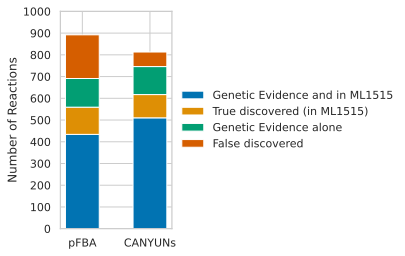

<Figure size 432x576 with 0 Axes>

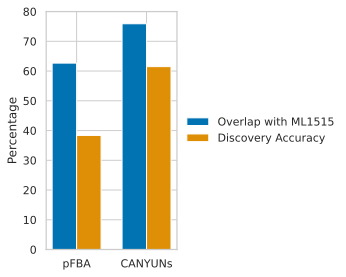

In [68]:
# Make Bar charts for dgFBA results
ind = np.arange(2)
width = 0.5

ML_confirmed = []
discovered = []
gene_confirmed = []
false_discovered = []
gene_confirmed_bottom = []
false_discovered_bottom = []
overall_acc_all = []
discovery_acc_all = []

for key in ['0','100']:
    result = result_dict[key]
    ML_confirmed.append(result[0])
    discovered.append(result[1])
    gene_confirmed.append(result[2])
    gene_confirmed_bottom.append(result[0]+result[1])
    false_discovered.append(result[3])
    false_discovered_bottom.append(result[0]+result[1]+result[2])
    # Percent Accuracy Scores
    overall_acc_all.append(result[4])
    discovery_acc_all.append(result[5])

%config InlineBackend.figure_format = 'svg'
plt.figure(figsize = (2, 4))
    
p1 = plt.bar(ind, ML_confirmed, width)
p2 = plt.bar(ind, discovered, width, bottom=ML_confirmed)
p3 = plt.bar(ind, gene_confirmed, width, bottom=gene_confirmed_bottom)
p4 = plt.bar(ind, false_discovered, width, bottom=false_discovered_bottom)

plt.ylabel('Number of Reactions')
# plt.title('Scores by group and gender')
plt.xticks(ind, ('pFBA','CANYUNs'))
plt.yticks(np.arange(0, 1001, 100))
plt.legend((p1[0], p2[0], p3[0], p4[0]),
           ('Genetic Evidence and in ML1515', 'True discovered (in ML1515)', 
            'Genetic Evidence alone', 'False discovered'),
            loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.show()

%config InlineBackend.figure_format = 'svg'
plt.figure(figsize = (6, 8))

# Create plot
fig, ax = plt.subplots(figsize = (5, 4))
bar_width = 0.35

rects1 = plt.bar(ind, overall_acc_all, bar_width, label='Overlap with ML1515')
rects2 = plt.bar(ind + bar_width, discovery_acc_all, bar_width, label='Discovery Accuracy')

plt.ylabel('Percentage')
plt.xticks(ind+ bar_width/2, ('pFBA','CANYUNs')) #  
plt.yticks(np.arange(0, 81, 10))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

plt.tight_layout()
plt.show()

In [69]:
# Heatmap 'Venn diagram'
CANYUN_usage_dict = make_usage_dict(universal_ML1515, CANYUN_outputs_subset_scores['100'][4], gng_dict_long)
canyun_rxn_ids = set(CANYUN_usage_dict.keys())

pFBA_usage_dict = make_usage_dict(universal_ML1515, CANYUN_outputs_subset_scores['0'][4], gng_dict_long)
pFBA_rxn_ids = set(pFBA_usage_dict.keys())

int_cellular_rxn_ids = []
for rxn in ML1515_exs.reactions:
    if rxn.id[0:3] not in ['EX_','SNK','Gro','sin','DM_','BIO','Bio']:
        int_cellular_rxn_ids.append(rxn.id)
ML1515_rxn_ids = set(int_cellular_rxn_ids)

rxns_w_ge = []
uni_rxn_ids = []
for rxn in universal_ML1515.reactions:
    if rxn.id[0:3] not in ['EX_','SNK','Gro','sin','DM_','BIO','Bio']:
        uni_rxn_ids.append(rxn.id)
        try:
            if rxn_scores_dict_alt[rxn.id][0] > 500.0:
                rxns_w_ge.append(rxn.id)
        except:
            continue
rxns_w_ge = set(rxns_w_ge)
uni_rxn_ids = set(uni_rxn_ids)

print('Total rxns set', len(uni_rxn_ids))

print('Rxns w/ evidence', len(rxns_w_ge))

print('CANYUN only',len(canyun_rxn_ids - ML1515_rxn_ids))

print('CANYUN Overlap', len(canyun_rxn_ids & ML1515_rxn_ids)/len(canyun_rxn_ids))

print('pFBA only',len(pFBA_rxn_ids - ML1515_rxn_ids))

print('pFBA Overlap', len(pFBA_rxn_ids & ML1515_rxn_ids)/len(pFBA_rxn_ids))

# Total rxns set 4140
# Rxns w/ evidence 2073
# CANYUN only 198
# CANYUN Overlap 0.7585365853658537
# pFBA only 337
# pFBA Overlap 0.6243032329988851

Total rxns set 4140
Rxns w/ evidence 2073
CANYUN only 196
CANYUN Overlap 0.7589175891758918
pFBA only 333
pFBA Overlap 0.6266816143497758


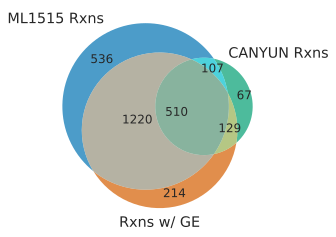

In [70]:
from matplotlib_venn import venn3
c = colors
venn3([ML1515_rxn_ids, canyun_rxn_ids, rxns_w_ge], set_colors=(c[0],c[2],c[3]), alpha=0.7,
      set_labels=('ML1515 Rxns', 'CANYUN Rxns', 'Rxns w/ GE'))
plt.show()

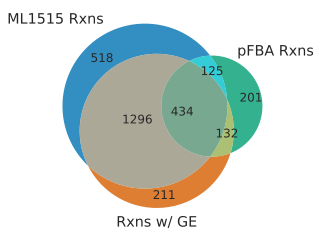

In [71]:
venn3([ML1515_rxn_ids, pFBA_rxn_ids, rxns_w_ge], set_colors=(c[0],c[2],c[3]), alpha=0.8,
      set_labels=('ML1515 Rxns', 'pFBA Rxns', 'Rxns w/ GE'))
plt.show()

In [72]:
# Compare CANYUN to ML1515
x = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99]
CAN_overall_acc= []
CAN_discovery_acc= []
CM_overall_acc= []
CM_discovery_acc= []
pfba_overall_acc = []
pfba_discovery_acc = []
CAN_discovered_rxns = []
CM_discovered_rxns = []
pfba_discovered_rxns = []
for threshold in x:
    CAN_result = discovery_acc(ML1515_exs, ML1515_output, universal_ML1515, 
                               CANYUN_outputs_subset_scores['100'], thresh=threshold)
    CAN_overall_acc.append(CAN_result[4])
    CAN_discovery_acc.append(CAN_result[5])
    CAN_discovered_rxns.append(CAN_result[1])
    
    pfba_result = discovery_acc(ML1515_exs, ML1515_output, universal_ML1515, 
                                CANYUN_outputs_subset_scores['0'], thresh=threshold)
    pfba_overall_acc.append(pfba_result[4])
    pfba_discovery_acc.append(pfba_result[5])
    pfba_discovered_rxns.append(pfba_result[1])

Number of ML1515 Growth Conditions 196
Threshold set to: 0.0
Confirmed ML1515 reactions with Gene evidence: 510
True discovery without Gene evidence: 107
Reactions used with genetic evidence, but not in ML1515: 129
False discovery without Gene evidence: 67
Discovery without Gene Evidence Accuracy: 0.6149425287356322
617 out of 813 are true. 75.89 %
Number of ML1515 Growth Conditions 196
Threshold set to: 0.0
Confirmed ML1515 reactions with Gene evidence: 434
True discovery without Gene evidence: 125
Reactions used with genetic evidence, but not in ML1515: 132
False discovery without Gene evidence: 201
Discovery without Gene Evidence Accuracy: 0.3834355828220859
559 out of 892 are true. 62.67 %
Number of ML1515 Growth Conditions 196
Threshold set to: 0.05
Confirmed ML1515 reactions with Gene evidence: 279
True discovery without Gene evidence: 73
Reactions used with genetic evidence, but not in ML1515: 36
False discovery without Gene evidence: 23
Discovery without Gene Evidence Accuracy:

Number of ML1515 Growth Conditions 196
Threshold set to: 0.6
Confirmed ML1515 reactions with Gene evidence: 193
True discovery without Gene evidence: 57
Reactions used with genetic evidence, but not in ML1515: 27
False discovery without Gene evidence: 10
Discovery without Gene Evidence Accuracy: 0.8507462686567164
250 out of 287 are true. 87.11 %
Number of ML1515 Growth Conditions 196
Threshold set to: 0.6
Confirmed ML1515 reactions with Gene evidence: 147
True discovery without Gene evidence: 52
Reactions used with genetic evidence, but not in ML1515: 7
False discovery without Gene evidence: 34
Discovery without Gene Evidence Accuracy: 0.6046511627906976
199 out of 240 are true. 82.92 %
Number of ML1515 Growth Conditions 196
Threshold set to: 0.65
Confirmed ML1515 reactions with Gene evidence: 193
True discovery without Gene evidence: 55
Reactions used with genetic evidence, but not in ML1515: 27
False discovery without Gene evidence: 8
Discovery without Gene Evidence Accuracy: 0.8730

In [ ]:
# Number of ML1515 Growth Conditions 196
# Threshold set to: 0.0
# Confirmed ML1515 reactions with Gene evidence: 515
# True discovery without Gene evidence: 107
# Reactions used with genetic evidence, but not in ML1515: 131
# False discovery without Gene evidence: 67
# Discovery without Gene Evidence Accuracy: 0.6149425287356322
# 622 out of 820 are true. 75.85 %
# Number of ML1515 Growth Conditions 196
# Threshold set to: 0.0
# Confirmed ML1515 reactions with Gene evidence: 435
# True discovery without Gene evidence: 125
# Reactions used with genetic evidence, but not in ML1515: 135
# False discovery without Gene evidence: 202
# Discovery without Gene Evidence Accuracy: 0.382262996941896
# 560 out of 897 are true. 62.43 %
# Number of ML1515 Growth Conditions 196
# Threshold set to: 0.05
# Confirmed ML1515 reactions with Gene evidence: 281
# True discovery without Gene evidence: 73
# Reactions used with genetic evidence, but not in ML1515: 38
# False discovery without Gene evidence: 23
# Discovery without Gene Evidence Accuracy: 0.7604166666666666
# 354 out of 415 are true. 85.3 %
# Number of ML1515 Growth Conditions 196
# Threshold set to: 0.05
# Confirmed ML1515 reactions with Gene evidence: 206
# True discovery without Gene evidence: 78
# Reactions used with genetic evidence, but not in ML1515: 29
# False discovery without Gene evidence: 79
# Discovery without Gene Evidence Accuracy: 0.4968152866242038
# 284 out of 392 are true. 72.45 %
# Number of ML1515 Growth Conditions 196
# Threshold set to: 0.1
# Confirmed ML1515 reactions with Gene evidence: 258
# True discovery without Gene evidence: 68
# Reactions used with genetic evidence, but not in ML1515: 35
# False discovery without Gene evidence: 20
# Discovery without Gene Evidence Accuracy: 0.7727272727272727
# 326 out of 381 are true. 85.56 %
# Number of ML1515 Growth Conditions 196
# Threshold set to: 0.1
# Confirmed ML1515 reactions with Gene evidence: 191
# True discovery without Gene evidence: 72
# Reactions used with genetic evidence, but not in ML1515: 24
# False discovery without Gene evidence: 65
# Discovery without Gene Evidence Accuracy: 0.5255474452554745
# 263 out of 352 are true. 74.72 %
# Number of ML1515 Growth Conditions 196
# Threshold set to: 0.15
# Confirmed ML1515 reactions with Gene evidence: 247
# True discovery without Gene evidence: 67
# Reactions used with genetic evidence, but not in ML1515: 34
# False discovery without Gene evidence: 16
# Discovery without Gene Evidence Accuracy: 0.8072289156626506
# 314 out of 364 are true. 86.26 %
# Number of ML1515 Growth Conditions 196
# Threshold set to: 0.15
# Confirmed ML1515 reactions with Gene evidence: 183
# True discovery without Gene evidence: 68
# Reactions used with genetic evidence, but not in ML1515: 18
# False discovery without Gene evidence: 57
# Discovery without Gene Evidence Accuracy: 0.544
# 251 out of 326 are true. 76.99 %
# Number of ML1515 Growth Conditions 196
# Threshold set to: 0.2
# Confirmed ML1515 reactions with Gene evidence: 236
# True discovery without Gene evidence: 61
# Reactions used with genetic evidence, but not in ML1515: 33
# False discovery without Gene evidence: 13
# Discovery without Gene Evidence Accuracy: 0.8243243243243243
# 297 out of 343 are true. 86.59 %
# Number of ML1515 Growth Conditions 196
# Threshold set to: 0.2
# Confirmed ML1515 reactions with Gene evidence: 179
# True discovery without Gene evidence: 67
# Reactions used with genetic evidence, but not in ML1515: 13
# False discovery without Gene evidence: 50
# Discovery without Gene Evidence Accuracy: 0.5726495726495726
# 246 out of 309 are true. 79.61 %
# Number of ML1515 Growth Conditions 196
# Threshold set to: 0.25
# Confirmed ML1515 reactions with Gene evidence: 232
# True discovery without Gene evidence: 61
# Reactions used with genetic evidence, but not in ML1515: 33
# False discovery without Gene evidence: 12
# Discovery without Gene Evidence Accuracy: 0.8356164383561644
# 293 out of 338 are true. 86.69 %
# Number of ML1515 Growth Conditions 196
# Threshold set to: 0.25
# Confirmed ML1515 reactions with Gene evidence: 172
# True discovery without Gene evidence: 61
# Reactions used with genetic evidence, but not in ML1515: 13
# False discovery without Gene evidence: 41
# Discovery without Gene Evidence Accuracy: 0.5980392156862745
# 233 out of 287 are true. 81.18 %
# Number of ML1515 Growth Conditions 196
# Threshold set to: 0.3
# Confirmed ML1515 reactions with Gene evidence: 225
# True discovery without Gene evidence: 61
# Reactions used with genetic evidence, but not in ML1515: 33
# False discovery without Gene evidence: 10
# Discovery without Gene Evidence Accuracy: 0.8591549295774648
# 286 out of 329 are true. 86.93 %
# Number of ML1515 Growth Conditions 196
# Threshold set to: 0.3
# Confirmed ML1515 reactions with Gene evidence: 164
# True discovery without Gene evidence: 59
# Reactions used with genetic evidence, but not in ML1515: 12
# False discovery without Gene evidence: 38
# Discovery without Gene Evidence Accuracy: 0.6082474226804123
# 223 out of 273 are true. 81.68 %
# Number of ML1515 Growth Conditions 196
# Threshold set to: 0.35
# Confirmed ML1515 reactions with Gene evidence: 219
# True discovery without Gene evidence: 60
# Reactions used with genetic evidence, but not in ML1515: 32
# False discovery without Gene evidence: 10
# Discovery without Gene Evidence Accuracy: 0.8571428571428571
# 279 out of 321 are true. 86.92 %
# Number of ML1515 Growth Conditions 196
# Threshold set to: 0.35
# Confirmed ML1515 reactions with Gene evidence: 157
# True discovery without Gene evidence: 58
# Reactions used with genetic evidence, but not in ML1515: 12
# False discovery without Gene evidence: 38
# Discovery without Gene Evidence Accuracy: 0.6041666666666666
# 215 out of 265 are true. 81.13 %
# Number of ML1515 Growth Conditions 196
# Threshold set to: 0.4
# Confirmed ML1515 reactions with Gene evidence: 214
# True discovery without Gene evidence: 60
# Reactions used with genetic evidence, but not in ML1515: 31
# False discovery without Gene evidence: 10
# Discovery without Gene Evidence Accuracy: 0.8571428571428571
# 274 out of 315 are true. 86.98 %
# Number of ML1515 Growth Conditions 196
# Threshold set to: 0.4
# Confirmed ML1515 reactions with Gene evidence: 153
# True discovery without Gene evidence: 56
# Reactions used with genetic evidence, but not in ML1515: 12
# False discovery without Gene evidence: 38
# Discovery without Gene Evidence Accuracy: 0.5957446808510638
# 209 out of 259 are true. 80.69 %
# Number of ML1515 Growth Conditions 196
# Threshold set to: 0.45
# Confirmed ML1515 reactions with Gene evidence: 207
# True discovery without Gene evidence: 60
# Reactions used with genetic evidence, but not in ML1515: 30
# False discovery without Gene evidence: 10
# Discovery without Gene Evidence Accuracy: 0.8571428571428571
# 267 out of 307 are true. 86.97 %
# Number of ML1515 Growth Conditions 196
# Threshold set to: 0.45
# Confirmed ML1515 reactions with Gene evidence: 149
# True discovery without Gene evidence: 54
# Reactions used with genetic evidence, but not in ML1515: 11
# False discovery without Gene evidence: 37
# Discovery without Gene Evidence Accuracy: 0.5934065934065934
# 203 out of 251 are true. 80.88 %
# Number of ML1515 Growth Conditions 196
# Threshold set to: 0.5
# Confirmed ML1515 reactions with Gene evidence: 202
# True discovery without Gene evidence: 59
# Reactions used with genetic evidence, but not in ML1515: 29
# False discovery without Gene evidence: 10
# Discovery without Gene Evidence Accuracy: 0.855072463768116
# 261 out of 300 are true. 87.0 %
# Number of ML1515 Growth Conditions 196
# Threshold set to: 0.5
# Confirmed ML1515 reactions with Gene evidence: 146
# True discovery without Gene evidence: 53
# Reactions used with genetic evidence, but not in ML1515: 11
# False discovery without Gene evidence: 36
# Discovery without Gene Evidence Accuracy: 0.5955056179775281
# 199 out of 246 are true. 80.89 %
# Number of ML1515 Growth Conditions 196
# Threshold set to: 0.55
# Confirmed ML1515 reactions with Gene evidence: 200
# True discovery without Gene evidence: 57
# Reactions used with genetic evidence, but not in ML1515: 29
# False discovery without Gene evidence: 10
# Discovery without Gene Evidence Accuracy: 0.8507462686567164
# 257 out of 296 are true. 86.82 %
# Number of ML1515 Growth Conditions 196
# Threshold set to: 0.55
# Confirmed ML1515 reactions with Gene evidence: 146
# True discovery without Gene evidence: 52
# Reactions used with genetic evidence, but not in ML1515: 10
# False discovery without Gene evidence: 36
# Discovery without Gene Evidence Accuracy: 0.5909090909090909
# 198 out of 244 are true. 81.15 %
# Number of ML1515 Growth Conditions 196
# Threshold set to: 0.6
# Confirmed ML1515 reactions with Gene evidence: 195
# True discovery without Gene evidence: 57
# Reactions used with genetic evidence, but not in ML1515: 29
# False discovery without Gene evidence: 10
# Discovery without Gene Evidence Accuracy: 0.8507462686567164
# 252 out of 291 are true. 86.6 %
# Number of ML1515 Growth Conditions 196
# Threshold set to: 0.6
# Confirmed ML1515 reactions with Gene evidence: 145
# True discovery without Gene evidence: 52
# Reactions used with genetic evidence, but not in ML1515: 10
# False discovery without Gene evidence: 36
# Discovery without Gene Evidence Accuracy: 0.5909090909090909
# 197 out of 243 are true. 81.07 %
# Number of ML1515 Growth Conditions 196
# Threshold set to: 0.65
# Confirmed ML1515 reactions with Gene evidence: 194
# True discovery without Gene evidence: 55
# Reactions used with genetic evidence, but not in ML1515: 29
# False discovery without Gene evidence: 8
# Discovery without Gene Evidence Accuracy: 0.873015873015873
# 249 out of 286 are true. 87.06 %
# Number of ML1515 Growth Conditions 196
# Threshold set to: 0.65
# Confirmed ML1515 reactions with Gene evidence: 140
# True discovery without Gene evidence: 48
# Reactions used with genetic evidence, but not in ML1515: 7
# False discovery without Gene evidence: 32
# Discovery without Gene Evidence Accuracy: 0.6
# 188 out of 227 are true. 82.82 %
# Number of ML1515 Growth Conditions 196
# Threshold set to: 0.7
# Confirmed ML1515 reactions with Gene evidence: 189
# True discovery without Gene evidence: 55
# Reactions used with genetic evidence, but not in ML1515: 25
# False discovery without Gene evidence: 7
# Discovery without Gene Evidence Accuracy: 0.8870967741935484
# 244 out of 276 are true. 88.41 %
# Number of ML1515 Growth Conditions 196
# Threshold set to: 0.7
# Confirmed ML1515 reactions with Gene evidence: 134
# True discovery without Gene evidence: 48
# Reactions used with genetic evidence, but not in ML1515: 7
# False discovery without Gene evidence: 28
# Discovery without Gene Evidence Accuracy: 0.631578947368421
# 182 out of 217 are true. 83.87 %
# Number of ML1515 Growth Conditions 196
# Threshold set to: 0.75
# Confirmed ML1515 reactions with Gene evidence: 188
# True discovery without Gene evidence: 55
# Reactions used with genetic evidence, but not in ML1515: 25
# False discovery without Gene evidence: 7
# Discovery without Gene Evidence Accuracy: 0.8870967741935484
# 243 out of 275 are true. 88.36 %
# Number of ML1515 Growth Conditions 196
# Threshold set to: 0.75
# Confirmed ML1515 reactions with Gene evidence: 133
# True discovery without Gene evidence: 47
# Reactions used with genetic evidence, but not in ML1515: 6
# False discovery without Gene evidence: 23
# Discovery without Gene Evidence Accuracy: 0.6714285714285714
# 180 out of 209 are true. 86.12 %
# Number of ML1515 Growth Conditions 196
# Threshold set to: 0.8
# Confirmed ML1515 reactions with Gene evidence: 183
# True discovery without Gene evidence: 55
# Reactions used with genetic evidence, but not in ML1515: 25
# False discovery without Gene evidence: 7
# Discovery without Gene Evidence Accuracy: 0.8870967741935484
# 238 out of 270 are true. 88.15 %
# Number of ML1515 Growth Conditions 196
# Threshold set to: 0.8
# Confirmed ML1515 reactions with Gene evidence: 133
# True discovery without Gene evidence: 47
# Reactions used with genetic evidence, but not in ML1515: 5
# False discovery without Gene evidence: 21
# Discovery without Gene Evidence Accuracy: 0.6911764705882353
# 180 out of 206 are true. 87.38 %
# Number of ML1515 Growth Conditions 196
# Threshold set to: 0.85
# Confirmed ML1515 reactions with Gene evidence: 176
# True discovery without Gene evidence: 54
# Reactions used with genetic evidence, but not in ML1515: 23
# False discovery without Gene evidence: 7
# Discovery without Gene Evidence Accuracy: 0.8852459016393442
# 230 out of 260 are true. 88.46 %
# Number of ML1515 Growth Conditions 196
# Threshold set to: 0.85
# Confirmed ML1515 reactions with Gene evidence: 128
# True discovery without Gene evidence: 47
# Reactions used with genetic evidence, but not in ML1515: 4
# False discovery without Gene evidence: 20
# Discovery without Gene Evidence Accuracy: 0.7014925373134329
# 175 out of 199 are true. 87.94 %
# Number of ML1515 Growth Conditions 196
# Threshold set to: 0.9
# Confirmed ML1515 reactions with Gene evidence: 171
# True discovery without Gene evidence: 52
# Reactions used with genetic evidence, but not in ML1515: 20
# False discovery without Gene evidence: 5
# Discovery without Gene Evidence Accuracy: 0.9122807017543859
# 223 out of 248 are true. 89.92 %
# Number of ML1515 Growth Conditions 196
# Threshold set to: 0.9
# Confirmed ML1515 reactions with Gene evidence: 122
# True discovery without Gene evidence: 45
# Reactions used with genetic evidence, but not in ML1515: 2
# False discovery without Gene evidence: 17
# Discovery without Gene Evidence Accuracy: 0.7258064516129032
# 167 out of 186 are true. 89.78 %
# Number of ML1515 Growth Conditions 196
# Threshold set to: 0.95
# Confirmed ML1515 reactions with Gene evidence: 156
# True discovery without Gene evidence: 44
# Reactions used with genetic evidence, but not in ML1515: 18
# False discovery without Gene evidence: 2
# Discovery without Gene Evidence Accuracy: 0.9565217391304348
# 200 out of 220 are true. 90.91 %
# Number of ML1515 Growth Conditions 196
# Threshold set to: 0.95
# Confirmed ML1515 reactions with Gene evidence: 102
# True discovery without Gene evidence: 38
# Reactions used with genetic evidence, but not in ML1515: 2
# False discovery without Gene evidence: 10
# Discovery without Gene Evidence Accuracy: 0.7916666666666666
# 140 out of 152 are true. 92.11 %
# Number of ML1515 Growth Conditions 196
# Threshold set to: 0.99
# Confirmed ML1515 reactions with Gene evidence: 129
# True discovery without Gene evidence: 40
# Reactions used with genetic evidence, but not in ML1515: 9
# False discovery without Gene evidence: 1
# Discovery without Gene Evidence Accuracy: 0.975609756097561
# 169 out of 179 are true. 94.41 %
# Number of ML1515 Growth Conditions 196
# Threshold set to: 0.99
# Confirmed ML1515 reactions with Gene evidence: 83
# True discovery without Gene evidence: 33
# Reactions used with genetic evidence, but not in ML1515: 1
# False discovery without Gene evidence: 7
# Discovery without Gene Evidence Accuracy: 0.825
# 116 out of 124 are true. 93.55 %

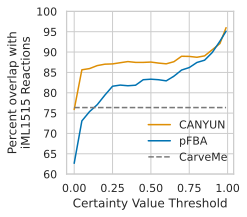

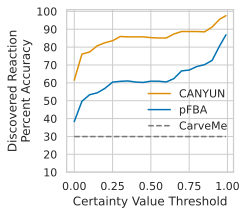

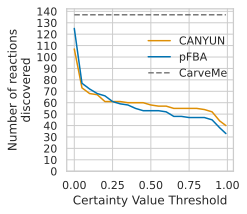

In [73]:
x = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99]

size_x = 3
size_y = 3
x_legend = .43
plt.figure(figsize = (size_x, size_y))
plt.plot(x,CAN_overall_acc,label='CANYUN', color=colors[1])
plt.plot(x,pfba_overall_acc,label='pFBA', color=colors[0])
plt.plot(x,[cm_overlap*100]*len(x),label='CarveMe', linestyle='dashed', color=muted[7])

plt.xlabel('Certainty Value Threshold')
plt.ylabel('Percent overlap with\niML1515 Reactions')
plt.legend(loc='center left', bbox_to_anchor=(x_legend, 0.2), ncol=1)
plt.yticks(np.arange(60, 101, 5))
# plt.savefig('figure.png', bbox_inches='tight')
# %config InlineBackend.figure_format = 'svg'
plt.show()

plt.figure(figsize = (size_x, size_y))
plt.plot(x,CAN_discovery_acc,label='CANYUN', color=colors[1])
plt.plot(x,pfba_discovery_acc,label='pFBA', color=colors[0])
plt.plot(x,[cm_discovered_acc*100]*len(x),label='CarveMe', linestyle='dashed', color=muted[7])

plt.xlabel('Certainty Value Threshold')
plt.ylabel('Discovered Reaction\nPercent Accuracy')
plt.legend(loc='center left', bbox_to_anchor=(x_legend, 0.38), ncol=1)
plt.yticks(np.arange(10, 101, 10))
# plt.savefig('figure.png', bbox_inches='tight')
# %config InlineBackend.figure_format = 'svg'
plt.show()

plt.figure(figsize = (size_x, size_y))
plt.plot(x,CAN_discovered_rxns,label='CANYUN', color=colors[1])
plt.plot(x,pfba_discovered_rxns,label='pFBA', color=colors[0])
plt.plot(x,[cm_total_num_discovered]*len(x),label='CarveMe', linestyle='dashed', color=muted[7])

plt.xlabel('Certainty Value Threshold')
plt.ylabel('Number of reactions\ndiscovered')
plt.legend(loc='center left', bbox_to_anchor=(x_legend, 0.7), ncol=1)
plt.yticks(np.arange(0, 141, 10))
# plt.savefig('figure.png', bbox_inches='tight')
# %config InlineBackend.figure_format = 'svg'
plt.show()

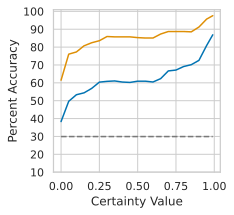

In [74]:
x = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99]

size_x = 3
size_y = 3
x_legend = .43

plt.figure(figsize = (size_x, size_y))
plt.plot(x,CAN_discovery_acc, label='CANYUN', color=colors[1])
plt.plot(x,pfba_discovery_acc, label='pFBA', color=colors[0])
plt.plot(x,[cm_discovered_acc*100]*len(x),label='CarveMe', linestyle='dashed', color=muted[7])

plt.xlabel('Certainty Value')
plt.ylabel('Percent Accuracy')
# plt.legend(loc='center left', bbox_to_anchor=(x_legend, 0.38), ncol=1)
plt.yticks(np.arange(10, 101, 10))
# plt.savefig('figure.png', bbox_inches='tight')
# %config InlineBackend.figure_format = 'svg'
plt.show()

# Exploring Usage Values

Growth conditions: 196
Reactions: 671
35663.345771205626


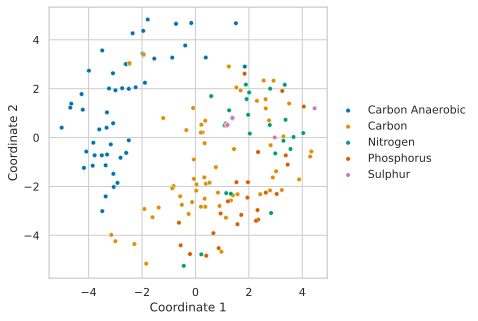

In [86]:
# PCoA of flux distributions for all growth conditions used to calculate the usage values

growth_keys = []
for key, gng in gng_dict_long.items():
    if gng > 0.0 and key in CANYUN_output[4].keys():
        growth_keys.append(key)

X = []
for key in growth_keys:
    solution = CANYUN_output[4][key]
    subX = []
    for rxn_id in list(CANYUN_usage_dict.keys()):
        if max(CANYUN_usage_dict[rxn_id]) > 0.0 and max(CANYUN_usage_dict[rxn_id]) < 1.0:
            if abs(solution.fluxes[rxn_id]) > 1e-6:
                subX.append(solution.fluxes[rxn_id]/1000)
            else:
                subX.append(0)
    X.append(subX)
    
print('Growth conditions:',len(X))
print('Reactions:',len(X[0]))

from sklearn.decomposition import PCA
from sklearn.manifold import MDS

np.random.seed(42)
embedding = MDS(n_components=2)
principalComponents = embedding.fit_transform(X)
print(embedding.stress_)

# MDS Plots
x_c = []
y_c = []
x_c_an = []
y_c_an = []
x_n = []
y_n = []
x_p = []
y_p = []
x_s = []
y_s = []

for key, coords in zip(growth_keys,principalComponents):
    # Carbon
    if key.startswith('PM1') or key.startswith('PM2'):
        if key[-2:] == '_1':
            x_c.append(coords[0])
            y_c.append(coords[1])
        if key[-2:] == '_0':
            x_c_an.append(coords[0])
            y_c_an.append(coords[1])
    # Alt nitrogen sources
    elif key.startswith('PM3'): 
        x_n.append(coords[0])
        y_n.append(coords[1])
    # Alt phosphorus sources
    elif key.startswith('PM4A') or key.startswith('PM4B') or key.startswith('PM4C') or key.startswith('PM4D') or key.startswith('PM4E'):
        x_p.append(coords[0])
        y_p.append(coords[1])
    # Alt Sulphur sources
    elif key.startswith('PM4F') or key.startswith('PM4G') or key.startswith('PM4H'):
        x_s.append(coords[0])
        y_s.append(coords[1])
    else:
        print('ERROR')
        
%config InlineBackend.figure_format = 'svg'

plt.figure(figsize = (5, 5))
alpha_val = 1
size_val = 20
ax = sns.scatterplot(x=x_c_an, y=y_c_an, label='Carbon Anaerobic', alpha = alpha_val, s = size_val)
ax = sns.scatterplot(x=x_c, y=y_c, label='Carbon', alpha = alpha_val, s = size_val)
ax = sns.scatterplot(x=x_n, y=y_n, label='Nitrogen', alpha = alpha_val, s = size_val)
ax = sns.scatterplot(x=x_p, y=y_p, label='Phosphorus', alpha = alpha_val, s = size_val)
ax = sns.scatterplot(x=x_s, y=y_s, label='Sulphur', alpha = alpha_val, s = size_val)

plt.xlabel('Coordinate 1')
plt.ylabel('Coordinate 2')
# ax.set_title('PCoA Growth vs. No Growth')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)
plt.show()

Number of used reactions that are reversible 307
Number of reversible reactions with Usage Values in both directions 46
Number of reversible reactions with Usage Values in both directions 261


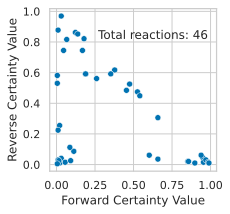

In [75]:
# Check used reactions for reversibility
count = 0
rev_rxns = []
for key in CANYUN_usage_dict.keys():
    rxn = universal_ML1515.reactions.get_by_id(key)
    if rxn.lower_bound < 0.0 and rxn.upper_bound > 0.0:
        count += 1
        rev_rxns.append(rxn.id)
print('Number of used reactions that are reversible', count)

# Reactions with Usage in both directions
x = []
y = []
count = 0
count_oneway = 0
cumulative_values = []
for rxn_id in rev_rxns:
    if rxn_id[0:3] not in ['EX_','SNK','Gro','sin','DM_','BIO','Bio']:
        vals = CANYUN_usage_dict[rxn_id]
        if vals[0] > 0.0 and vals[1] > 0.0:
            x.append(vals[0])
            y.append(vals[1])
            count += 1
            cumulative_values.append(vals[0] + vals[1])
        elif vals[0] > 0.0 or vals[1] > 0.0:
            count_oneway += 1


plt.figure(figsize=(3,3))
ax = sns.scatterplot(x=x, y=y) # 
plt.xlabel('Forward Certainty Value')
plt.ylabel('Reverse Certainty Value')
ax.text(.27, .82, 'Total reactions: '+str(count))
# ax.set_title('Forward vs. Reverse Certainty Value')
print('Number of reversible reactions with Usage Values in both directions', count)
print('Number of reversible reactions with Usage Values in both directions', count_oneway)

(-5.0, 170.0)

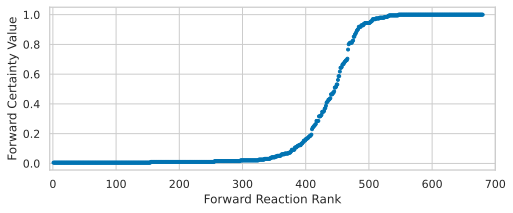

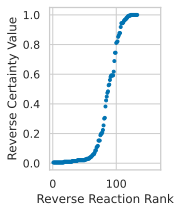

In [76]:
fwd_vals = []
rev_vals = []

for key, vals in CANYUN_usage_dict.items():
    if key[0:3] not in ['EX_','SNK','Gro','sin','DM_','BIO','Bio']:
        if vals[0] > 0.0 and vals[1] == 0.0:
            fwd_vals.append(vals[0])
        elif vals[0] == 0.0 or vals[1] > 0.0:
            rev_vals.append(vals[1])

fwd_vals.sort()
x = list(range(1, len(fwd_vals)+1))

plt.figure(figsize = (8,3))
plt.plot(x, fwd_vals, marker='.', linestyle='')
plt.xlabel('Forward Reaction Rank')
plt.ylabel('Forward Certainty Value')
plt.xlim([-5, 700])

rev_vals.sort()
x = list(range(1, len(rev_vals)+1))

plt.figure(figsize = (2,3))
plt.plot(x, rev_vals, marker='.', linestyle='')
plt.xlabel('Reverse Reaction Rank')
plt.ylabel('Reverse Certainty Value')
plt.xlim([-5, 170])

In [77]:
# Used reactions with CVs less than 500 or missing
for rxn_id, values in CANYUN_usage_dict.items():
    if sum(values) > 0.0 and rxn_id not in [rxn.id for rxn in ML1515_exs.reactions]:
        try: 
            if rxn_scores_dict_alt[rxn_id][0] < 500:
                print(rxn_scores_dict_alt[rxn_id], rxn_id, universal_ML1515.reactions.get_by_id(rxn_id).name)
        except:
            print('Missing Gene', rxn_id, universal_ML1515.reactions.get_by_id(rxn_id).name)

[157.53333333333333] FE3t Ferric iron uptake, plasma membrane
[470.3] URIDK2r Uridylate kinase (dUMP)
[340.9] ALCD2y ALCD2y
[1.0] CO2t CO2 transporter via diffusion
[446.0] H2Ot H2O transport via diffusion
[1.0] O2t O2 transport  diffusion 
[149.4] STPT1 Phosphoserine:homoserine phosphotransferase
[331.3] GLCAASE3 Beta-glucuronidase (tryptophanyl)
Missing Gene HSERTA Homoserine O trans acetylase
[128.6] INSTt2 Inositol transport in via proton symport
[172.9] ORNTAC Ornithine transacetylase
Missing Gene AHSERL2 O acetylhomoserine  thiol  lyase
[114.2] FLNDPR2r Flavodoxin : nadp reductase
Missing Gene GLCURT Glucuronosyltransferase (tryptophanyl)
[1.0] ACALDt Acetaldehyde reversible transport
Missing Gene H2CO3D2 H2CO3D2
Missing Gene H2CO3TP H2CO3TP
[344.95] FDH Formate dehydrogenase
[49.3] PRUK Phosphoribulokinase
Missing Gene MMSAD3 MMSAD3
Missing Gene RBPC Ribulose-bisphosphate carboxylase
[59.7] INOSR Ketoinositol reductase
Missing Gene INSCR Inositol catabolic reactions  lumped 
[22

In [ ]:

# [157.53333333333333] FE3t Ferric iron uptake, plasma membrane
# [1.0] CO2t CO2 transporter via diffusion
# [340.9] ALCD2y ALCD2y
# [149.4] STPT1 Phosphoserine:homoserine phosphotransferase
# [1.0] O2t O2 transport  diffusion 
# [446.0] H2Ot H2O transport via diffusion
# [470.3] URIDK2r Uridylate kinase (dUMP)
# Missing Gene AHSERL2 O acetylhomoserine  thiol  lyase
# [331.3] GLCAASE3 Beta-glucuronidase (tryptophanyl)
# [128.6] INSTt2 Inositol transport in via proton symport
# Missing Gene GLCURT Glucuronosyltransferase (tryptophanyl)
# [172.9] ORNTAC Ornithine transacetylase
# Missing Gene HSERTA Homoserine O trans acetylase
# [114.2] FLNDPR2r Flavodoxin : nadp reductase
# [1.0] ACALDt Acetaldehyde reversible transport
# Missing Gene H2CO3TP H2CO3TP
# Missing Gene H2CO3D2 H2CO3D2
# [344.95] FDH Formate dehydrogenase
# [59.7] INOSR Ketoinositol reductase
# Missing Gene RBPC Ribulose-bisphosphate carboxylase
# [49.3] PRUK Phosphoribulokinase
# Missing Gene INSCR Inositol catabolic reactions  lumped 
# Missing Gene MMSAD3 MMSAD3
# [224.9] SBTt2 D sorbitol transport in via proton symport
# [258.8] SBTD_D2 D sorbitol dehydrogenase  D fructose producing 
# [20.02] HYDFDN Ferredoxin NADH linked hydrogenase
# [389.0] MMSAD2 Methylmalonate-semialdehyde dehydrogenase (propanol)
# [106.9] NADFADOR NAD:FAD oxidoreductase
# [100.1] INS2D Inositol 2-dehydrogenase
# [123.2] FBA2 D Fructose 1 phosphate D glyceraldehyde 3 phosphate lyase
# Missing Gene CYTOM Cytosine 5 methyltransferase
# [146.0] MCSNAH 5-Methylcytosine aminohydrolase
# [44.7] METGL METGL
# Missing Gene MSULR MSULR
# [337.4] ALDD1 ALDD1
# Missing Gene LALDO D-Lactaldehyde NAD+ oxidoreductase (glutathione-formylating)
# Missing Gene LCARR Lacaldehyde reductase (R-propane-1,2-diol forming)
# [357.8] FFSD Beta-fructofuranosidase
# [288.9] URATEt_1 Urate permease
# [273.9] SKMt2 SKMt2
# [84.7] ARGt5r ARGt5r
# Missing Gene ARGN_1 Arginase
# [96.7] OCBT_1 Ornithine carbamoyltransferase
# [1.0] St St
# [90.5] APENTAMAH APENTAMAH
# Missing Gene GLUTCOADHc GLUTCOADHc
# [1.0] NH3c Ammomnium proton dissociation
# Missing Gene LYSMO LYSMO
# [1.0] H2St H2St
# Missing Gene PHYCBOXL PHYCBOXL
# Missing Gene ORNt2 Ornithine transport in via proton symport
# Missing Gene PPIabc Diphosphate transport in via ABC system
# Missing Gene TMPHi Trimetaphosphate hydrolase
# Missing Gene TMPt6 TMP transport inout via proton symport
# Missing Gene 2PGt6pp D Glycerate 2 phosphate phosphate antiporter periplasm 
# Missing Gene 3PGt6pp 3 Phospho D glycerate phosphate antiporter periplasm 
# Missing Gene PEPt6 Phosphoenolpyruvate transport in via proton symport
# Missing Gene 2PGLYCt6 2 Phosphoglycolate transport inout via proton symport
# Missing Gene MAN1Pt6 MAN1P transport inout via proton symport
# Missing Gene PSP_D PSP D
# Missing Gene PSER_Dt6 D O Phosphoserine transport inout via proton symport
# Missing Gene AEPabcpp AEP transport via ABC system periplasm 
# Missing Gene PALDH Phosphonoacetaldehyde hydrolase
# Missing Gene AEPPYRTA 2 aminoethylphosphonate pyruvate transaminase
# Missing Gene AHSERL4 Cysteine synthase  Thiosulfate 
# Missing Gene TETDHpp3 Tetrathionate Dehydrogenase ubiquinone 8  periplasm 
# Missing Gene CYSTabc L cystine transport via ABC system

In [ ]:
# universal_ML1515.reactions.get_by_id('DHNPA_1')
# https://biocyc.org/ECOLI/NEW-IMAGE?type=REACTION&object=H2NEOPTERINALDOL-RXN

# CarveMe Check

In [90]:
# Check CarveMe Gapfilled for mass generating loops with semi-novel algorithm 
count = 0
for model in [gapfilled_carve_exs] + [gapfilled_carve]: # CM_model_list +
    count += 1
    print('Model:',count)
    model_exs_snks = add_exs(model, universal_ML1515, feasible_media_conditions)
    rxn_ids = [rxn.id for rxn in model_exs_snks.reactions]

    # Add any missing intracellular sink reactions
    for met in model_exs_snks.metabolites:
        if met.id.endswith('_p') or met.id.endswith('_c'):
            if 'SNK_' + met.id not in rxn_ids:
                snk_rxn = Reaction('SNK_' + met.id)
                snk_rxn.name = "Sink reaction for " + met.id
                snk_rxn.lower_bound = 0.0
                snk_rxn.upper_bound = 0.0
                snk_rxn.add_metabolites({met:-1})
                model_exs_snks.add_reactions([snk_rxn])

    # Set exchanges to allow all extracellular metabolites leave the system
    for rxn in model_exs_snks.reactions:
        if rxn.id.startswith('EX_'):
            rxn.lower_bound = 0.0    # Don't allow mets in
            rxn.upper_bound = 1000.0 # Allow mets out

    # Set all intracellular sink reactions open to allow mets out
    for rxn in model_exs_snks.reactions:
        if rxn.id.startswith('SNK_'):
            rxn.upper_bound = 1000.0

    expr = Zero
    for rxn in model_exs_snks.reactions:
        if rxn.id.startswith('SNK_'): # and rxn.id != 'SNK_h_c' and rxn.id != 'SNK_h2_c' and rxn.id != 'SNK_gcald_c':
            if rxn.upper_bound != 0.0:
                expr += 1.0 * rxn.forward_variable
                expr += 1.0 * rxn.reverse_variable

    model_exs_snks.objective = model_exs_snks.problem.Objective(expr, direction='max', sloppy=True)
    model_exs_snks.solver.update()
    solution = model_exs_snks.optimize()

    # Save reactions that carry flux
    active_rxns_loops = set([rxn.id for rxn in model_exs_snks.reactions if abs(solution.fluxes[rxn.id]) > 1e-6])
    print(solution.objective_value)
    if abs(solution.objective_value) < 1e-6:
        print('No mass generation!')

    print(model_exs_snks.solver.status)

    # Check for mass imbalanced reactions
    for rxn_id in active_rxns_loops:
        if rxn_id.startswith('SNK'):
            print('Metabolite produced:', rxn_id)
    print('-------------------')

Model: 1
Exchanges add: 0


/home/tjmoutinho/CanyonGENREs-testing/canyuns/lib/python3.6/site-packages/cobra/util/solver.py:508: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


0.8517047681825687
infeasible
Metabolite produced: SNK_tsul_c
-------------------
Model: 2
Exchanges add: 17
0.0
No mass generation!
optimal
-------------------


In [92]:
# pFBA with CarveMe Model
gap_CM = cobra.io.read_sbml_model('nonGapfilledEcoliModel.xml')
gap_CM_exs = add_exs(gap_CM, universal_ML1515, well_id_media_dict_ML1515)

t0 = time.time()
CM_pfba_weights = convert_to_weight_space(gap_CM_exs, rxn_scores_dict_alt, pfba=True)
CM_pfba_expr = write_dgFBA_expr(gap_CM_exs, CM_pfba_weights)
gap_CM_pfba_output = make_canyun(gap_CM_exs, CM_pfba_expr, well_id_media_dict_ML1515, 'Biomass')
# CM_pfba_usage_dict = make_usage_dict(gap_CM_exs, CM_pfba_output[4], gng_dict_long)
t1 = time.time()

total = t1-t0
print(str(total)+' Secounds')

calc_acc(gap_CM_pfba_output)

Exchanges add: 29
59.53200554847717 Secounds
Accuracy: 0.5274725274725275
True Pos 100
False Pos 30
True Neg 44
False Neg 99
-------------------


0.5274725274725275

In [93]:
mcc_calc(gap_CM_pfba_output)

0.08642789676445951

In [92]:
100+30+44+99

273

## Save Universal to JSON format

In [3]:
from cobra.io import save_json_model
m = pickle.load(open('bigg_universal_moutinho_2.pickle','rb'))
for rxn in m.reactions: rxn.annotation = {}
for met in m.metabolites: met.annotation = {}
for gene in m.genes: gene.annotation = {}
m.annotation = {}
save_json_model(m,'bigg_universal_moutinho_2_MEMOTE_check.json')

In [4]:
from cobra.io import save_json_model
m2 = pickle.load(open('carveme_universal_moutinho.pickle','rb'))
for rxn in m2.reactions: rxn.annotation = {}
for met in m2.metabolites: met.annotation = {}
for gene in m2.genes: gene.annotation = {}
m2.annotation = {}
save_json_model(m2,'carveme_universal_moutinho_MEMOTE_check.json')